# Linear Regression and Neural Network models
## Step by step plan:

Data ingestion<br>

Data wrangling and feature engineering
- Outlier removal<br>
- Tokenization and cleanup of job titles<br>
- Creation of dummies for all categorical variables<br>

*Train test split*<br>

Post split wrangling<br>
- Feature selection and database cleanup<br>
- Independent variable normalization<br>

### Model creation and evaluation
- Parameter evaluation<br>
- Actual vs predicted target variable analysis<br>
- Residuals analysis<br>

### Created models:
- One linear model<br>
- One linear model using exclusively significant independent variables<br>
- One neural network model<br>
- One linear model using PCA (some exploratory analysis is done for PCA results)<br>

### Attempted improvements:
- OLS model using exclusively significant independent variables using all available options of robust standard errors<br>
- Layered OLS model using exclusively significant independent variables and Experience Level as a layer breakdown - available in a different Jupyter Notebook<br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from math import ceil, floor
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox, normaltest, kstest, pearsonr
from scipy.special import inv_boxcox

In [2]:
sns.set() # makes all charts look better by default

## Data Ingestion

In [3]:
aijobs = pd.read_csv(r'https://ai-jobs.net/salaries/download/salaries.csv')
# Last accessed at 2024-03-23

In [4]:
aijobs # first look at the data

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,MI,FT,Data Engineer,120000,CHF,136363,CH,50,CH,L
1,2024,SE,PT,Data Architect,212000,USD,212000,US,0,US,M
2,2024,SE,PT,Data Architect,93300,USD,93300,US,0,US,M
3,2024,MI,FT,Data Product Owner,321830,USD,321830,US,0,US,M
4,2024,MI,FT,Data Product Owner,124690,USD,124690,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
14796,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
14797,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
14798,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
14799,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [5]:
aijobs.describe(include='all')

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,14801.000000,14801,14801,14801,1.480100e+04,14801,14801.000000,14801,14801.000000,14801,14801
unique,NaN,4,4,152,NaN,23,NaN,88,NaN,77,3
top,NaN,SE,FT,Data Engineer,NaN,USD,NaN,US,NaN,US,M
freq,NaN,9673,14735,3158,NaN,13648,NaN,12896,NaN,12945,13638
mean,2023.136748,NaN,NaN,NaN,1.650843e+05,NaN,149895.249307,NaN,32.801838,NaN,NaN
std,0.700349,NaN,NaN,NaN,3.566669e+05,NaN,69037.515089,NaN,46.502476,NaN,NaN
min,2020.000000,NaN,NaN,NaN,1.400000e+04,NaN,15000.000000,NaN,0.000000,NaN,NaN
25%,2023.000000,NaN,NaN,NaN,1.021000e+05,NaN,102000.000000,NaN,0.000000,NaN,NaN
50%,2023.000000,NaN,NaN,NaN,1.422000e+05,NaN,141525.000000,NaN,0.000000,NaN,NaN
75%,2024.000000,NaN,NaN,NaN,1.875000e+05,NaN,185900.000000,NaN,100.000000,NaN,NaN


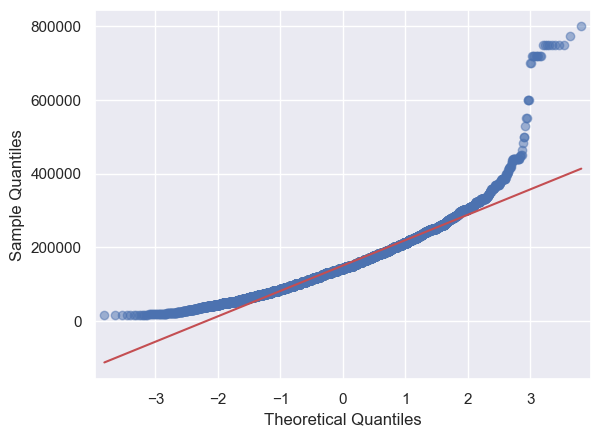

In [6]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

# Common data wrangling
These steps would be equally done for train and test bases with no population or sampled information, only individual ones, so no data leakage will occur if done now.

### Outlier removal

In [7]:
# The first outliers are extremely out of touch with the remainder of the database.
# They will skew the results too much and must be removed.
# According to Hair, from 2.5 to 4 standards deviations might be used to remove outliers.
# Visually, 4 deviations cover the worst cases.

mean = aijobs['salary_in_usd'].mean()
std = aijobs['salary_in_usd'].std()
outmax = mean + 4 * std
print(outmax)
outliers = aijobs[aijobs['salary_in_usd'] > outmax].index
print(outliers)
print(len(outliers))

aijobs.drop(outliers, inplace=True)
aijobs.reset_index(drop=True, inplace=True)
aijobs.sort_values('salary_in_usd', ascending=False).head()

426045.3096650862
Index([  153,   157,   410,   455,   569,   617,   892,   894,   902,  1071,
        1576,  1699,  1906,  1907,  1914,  1922,  2385,  2397,  2413,  2427,
        2455,  2483,  2573,  2577,  2713,  2889,  3113,  3300,  3519,  3804,
        3861,  3871,  3885,  3905,  3929,  4063,  4075,  4079,  4105,  4115,
        4119,  4673,  4679,  4982,  5333,  5609,  5657,  5765, 11095, 13095,
       14583],
      dtype='int64')
51


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
14742,2021,MI,FT,Applied Machine Learning Scientist,423000,USD,423000,US,50,US,L
3773,2024,SE,FT,Machine Learning Engineer,418000,USD,418000,US,100,US,M
3298,2024,SE,FT,Machine Learning Engineer,418000,USD,418000,US,100,US,M
11574,2023,SE,FT,AI Scientist,1500000,ILS,417937,IL,0,IL,L
14677,2021,EX,CT,Principal Data Scientist,416000,USD,416000,US,100,US,S


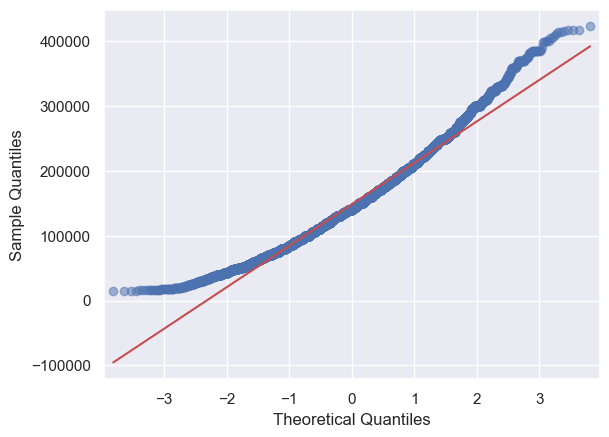

In [8]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

In [9]:
aijobs.describe(include='all')

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,14750.000000,14750,14750,14750,1.475000e+04,14750,14750.000000,14750,14750.000000,14750,14750
unique,NaN,4,4,152,NaN,23,NaN,88,NaN,77,3
top,NaN,SE,FT,Data Engineer,NaN,USD,NaN,US,NaN,US,M
freq,NaN,9650,14684,3156,NaN,13599,NaN,12849,NaN,12898,13587
mean,2023.134712,NaN,NaN,NaN,1.636749e+05,NaN,148422.371390,NaN,32.861017,NaN,NaN
std,0.699531,NaN,NaN,NaN,3.563792e+05,NaN,63942.227074,NaN,46.522770,NaN,NaN
min,2020.000000,NaN,NaN,NaN,1.400000e+04,NaN,15000.000000,NaN,0.000000,NaN,NaN
25%,2023.000000,NaN,NaN,NaN,1.020000e+05,NaN,101570.000000,NaN,0.000000,NaN,NaN
50%,2023.000000,NaN,NaN,NaN,1.420000e+05,NaN,141000.000000,NaN,0.000000,NaN,NaN
75%,2024.000000,NaN,NaN,NaN,1.868460e+05,NaN,185900.000000,NaN,100.000000,NaN,NaN


## Feature Engineering

In [10]:
# There is no value in local currency salaries as they're not scaled.
# Salary in USD conveys the same useful information in a scaled manner.
aijobs.drop('salary', axis=1, inplace=True)

In [11]:
# An interesting variable to research
aijobs['work_abroad'] = aijobs['employee_residence'] != aijobs['company_location']
aijobs['work_abroad'] = aijobs['work_abroad'].astype(int)
aijobs.tail(10)

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,work_abroad
14740,2021,SE,FT,Director of Data Science,USD,168000,JP,0,JP,S,0
14741,2021,MI,FT,Data Scientist,SGD,119059,SG,100,IL,M,1
14742,2021,MI,FT,Applied Machine Learning Scientist,USD,423000,US,50,US,L,0
14743,2021,MI,FT,Data Engineer,EUR,28369,MT,50,MT,L,0
14744,2021,SE,FT,Data Specialist,USD,165000,US,100,US,L,0
14745,2020,SE,FT,Data Scientist,USD,412000,US,100,US,L,0
14746,2021,MI,FT,Principal Data Scientist,USD,151000,US,100,US,L,0
14747,2020,EN,FT,Data Scientist,USD,105000,US,100,US,S,0
14748,2020,EN,CT,Business Data Analyst,USD,100000,US,100,US,L,0
14749,2021,SE,FT,Data Science Manager,INR,94665,IN,50,IN,L,0


In [12]:
# remote_ratio is categorical; the correct way to interpret those numbers is:
#   0 == On Site (less than 20% remote)
#  50 == Partially remote/hybird
# 100 == Fully remote (more than 80% remote)
# therefore using it as numerical would be creating a spurious relationship.
# It has to be dummified and will be switched for easier interpretation.

aijobs.loc[aijobs['remote_ratio'] == 0, 'remote_ratio'] = 'On_Site'
aijobs.loc[aijobs['remote_ratio'] == 50, 'remote_ratio'] = 'Hybrid'
aijobs.loc[aijobs['remote_ratio'] == 100, 'remote_ratio'] = 'Remote'

aijobs['remote_ratio']

0         Hybrid
1        On_Site
2        On_Site
3        On_Site
4        On_Site
          ...   
14745     Remote
14746     Remote
14747     Remote
14748     Remote
14749     Hybrid
Name: remote_ratio, Length: 14750, dtype: object

In [13]:
# Categorical columns will receive appropriate treatment
categorical_columns = ['experience_level', 'employment_type', 'salary_currency', 'employee_residence', 'remote_ratio', 
                       'company_location', 'company_size']

In [14]:
# Quick look at job titles. This will receive a quick NLP method for processing.
print(len(aijobs['job_title'].unique()), "different job titles \n")
print(aijobs['job_title'].unique())

152 different job titles 

['Data Engineer' 'Data Architect' 'Data Product Owner' 'MLOps Engineer'
 'Data Specialist' 'Data Manager' 'Analytics Engineer' 'Data Analyst'
 'Machine Learning Scientist' 'Business Intelligence Engineer'
 'Data Scientist' 'Business Intelligence Analyst' 'Data Science'
 'Data Analytics Manager' 'Encounter Data Management Professional'
 'Machine Learning Engineer' 'Research Scientist' 'Research Engineer'
 'AI Engineer' 'Data Modeler' 'Research Analyst' 'ML Engineer'
 'Data Science Consultant' 'Applied Scientist' 'BI Analyst'
 'Data Integration Engineer' 'Data Integration Specialist'
 'Machine Learning Operations Engineer'
 'Machine Learning Infrastructure Engineer' 'Data Developer'
 'Business Intelligence' 'CRM Data Analyst' 'ETL Developer'
 'Business Intelligence Manager' 'Data Science Engineer' 'AI Architect'
 'Robotics Engineer' 'BI Developer' 'Head of Data' 'Data Science Manager'
 'Cloud Database Engineer' 'Data Operations Analyst'
 'Data Science Analyst' 

In [15]:
# Work on the terms contained in job titles.
terms = []
for title in aijobs['job_title'].unique():
    for word in title.split():
        terms.append(word)
terms = sorted(set(terms))
print(len(terms), "different terms in these titles \n")
print(terms)

82 different terms in these titles 

['&', 'AI', 'AWS', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Autonomous', 'Azure', 'BI', 'Big', 'Biologist', 'Business', 'CRM', 'Cloud', 'Compliance', 'Computational', 'Computer', 'Consultant', 'Data', 'Database', 'Decision', 'Deep', 'DevOps', 'Developer', 'Director', 'ETL', 'Encounter', 'Engineer', 'Engineering', 'Finance', 'Financial', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Intelligence', 'Lead', 'Learning', 'ML', 'MLOps', 'Machine', 'Management', 'Manager', 'Managing', 'Marketing', 'Modeler', 'Modeller', 'NLP', 'Operations', 'Ops', 'Owner', 'Pipeline', 'Power', 'Practitioner', 'Principal', 'Product', 'Professional', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Research', 'Researcher', 'Robotics', 'Sales', 'Science', 'Scientist', 'Software', 'Specialist', 'Staff', 'Strategist', 'Strategy', 'Tech', 'Technician', 'Vehicle', 'Vision', 'Visualization', 'of']


In [16]:
stop_words = ['&', 'of', 'Data', 'Learning', 'Computational', 'Computer', 'Autonomous', 'Technician', 'Professional']
# Justification: '&', 'of' and 'Data' are too generic for this project.
# 'Learning' has two contexts: Machine Learning and Deep Learning, yet both "Machine" and "Deep" are unique to them,
# so there's nothing to be gained from adding it.
# "Autonomous Vehicle Technician" is a job title whose words are all unique, so a single one is enough.
# "Computational Biologist" shares the same issue.
# "Encounter Data Management Professional" is the only to use "Encounter" and "Professional".
# "Computer Vision" is present in more than one job, but all of them use this same sequence, so it's the same situation.

In [17]:
synonym_terms = ['ML','Machine','MLOps', 'Operations','Business','BI','Intelligence','AWS','Cloud','Azure','Modeller',
                 'Modeler','Engineering','Engineer','Financial','Finance','Researcher','Research','Science','Scientist',
                 'Strategy','Strategist','Management','Manager', 'Managing']

In [18]:
# this uses the same pressupositions as above, but some words will mean the same thing.
synonyms = {'Machine': 'Machine|ML|MLOps',      # ML is short for Machine Learning
            'Operations':'MLOps|Operations',    # Ops is short for Operations
            'Intelligence':'Intelligence|BI',   # BI is short for Business Intelligence (Intelligence is exclusive to BI)
            'Business':'Business|BI',           # For consistency (Business is not exclusive to BI)
            'Cloud':'Cloud|AWS|Azure',          # There is a single instance for AWS and for Azure; both specific cloud tools
            'Modeler':'Modeler|Modeller',
            'Engineer':'Engineer|Engineering',
            'Finance':'Finance|Financial',
            'Research':'Research|Researcher',
            'Scientist':'Scientist|Science',
            'Strategist':'Strategist|Strategy',
            'Manager':'Management|Manager|Managing'}
# Note: Analyst and Analytics in this context will mean different things.

In [19]:
clean_terms = terms.copy()                                                   # copy method to keep the original list
[clean_terms.remove(term) for term in stop_words if term in clean_terms]     # remove stop words
[clean_terms.remove(term) for term in synonym_terms if term in clean_terms]  # synonyms will be processed differently
print(len(clean_terms), "terms after cleaning\n", len(synonyms), "synonyms\n ", len(clean_terms)+len(synonyms), "total terms\n")
print(clean_terms)

48 terms after cleaning
 12 synonyms
  60 total terms

['AI', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Big', 'Biologist', 'CRM', 'Compliance', 'Consultant', 'Database', 'Decision', 'Deep', 'DevOps', 'Developer', 'Director', 'ETL', 'Encounter', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Lead', 'Marketing', 'NLP', 'Ops', 'Owner', 'Pipeline', 'Power', 'Practitioner', 'Principal', 'Product', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Robotics', 'Sales', 'Software', 'Specialist', 'Staff', 'Tech', 'Vehicle', 'Vision', 'Visualization']


In [20]:
# dummization for all chosen job keywords
for job_string in clean_terms:
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(job_string, case=False).astype(int)
for job_string in synonyms.keys():
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(f'{synonyms[job_string]}', case=False).astype(int)
aijobs.head()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,job_name_Intelligence,job_name_Business,job_name_Cloud,job_name_Modeler,job_name_Engineer,job_name_Finance,job_name_Research,job_name_Scientist,job_name_Strategist,job_name_Manager
0,2024,MI,FT,Data Engineer,CHF,136363,CH,Hybrid,CH,L,...,0,0,0,0,1,0,0,0,0,0
1,2024,SE,PT,Data Architect,USD,212000,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0
2,2024,SE,PT,Data Architect,USD,93300,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0
3,2024,MI,FT,Data Product Owner,USD,321830,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0
4,2024,MI,FT,Data Product Owner,USD,124690,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# dummization for all other categorical columns
df_dummies = pd.get_dummies(aijobs[categorical_columns], dtype=int)
aijobs = pd.concat([aijobs, df_dummies], axis=1)
aijobs.head()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,company_location_SI,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_location_ZA,company_size_L,company_size_M,company_size_S
0,2024,MI,FT,Data Engineer,CHF,136363,CH,Hybrid,CH,L,...,0,0,0,0,0,0,0,1,0,0
1,2024,SE,PT,Data Architect,USD,212000,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0
2,2024,SE,PT,Data Architect,USD,93300,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0
3,2024,MI,FT,Data Product Owner,USD,321830,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0
4,2024,MI,FT,Data Product Owner,USD,124690,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0


In [22]:
aijobs[categorical_columns].describe().loc['unique']

experience_level       4
employment_type        4
salary_currency       23
employee_residence    88
remote_ratio           3
company_location      77
company_size           3
Name: unique, dtype: object

In [23]:
# To establish the features, categorical columns that are not dummies will need to be removed. Target variable too.

X_vars = aijobs.columns.tolist()
[X_vars.remove(col) for col in categorical_columns if col in X_vars]
X_vars.remove('job_title')
X_vars.remove('salary_in_usd')

In [24]:
# Comprehensive dummies will need one instance removed.
# They could be picked by hand, but the algorithm below selects the most popular for deletion.

c_dummies = aijobs[['experience_level_EN', 'experience_level_MI', 'experience_level_SE', 'experience_level_EX']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['employment_type_FL', 'employment_type_PT', 'employment_type_CT', 'employment_type_FT']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['remote_ratio_Remote', 'remote_ratio_Hybrid', 'remote_ratio_On_Site']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['company_size_S', 'company_size_M', 'company_size_L']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

# These larger dummies will be implied in the intercept.
X_vars.remove('salary_currency_USD')
X_vars.remove('employee_residence_US')
X_vars.remove('company_location_US')

print(X_vars)

['work_year', 'work_abroad', 'job_name_AI', 'job_name_Admin', 'job_name_Analyst', 'job_name_Analytics', 'job_name_Applied', 'job_name_Architect', 'job_name_Associate', 'job_name_Big', 'job_name_Biologist', 'job_name_CRM', 'job_name_Compliance', 'job_name_Consultant', 'job_name_Database', 'job_name_Decision', 'job_name_Deep', 'job_name_DevOps', 'job_name_Developer', 'job_name_Director', 'job_name_ETL', 'job_name_Encounter', 'job_name_Head', 'job_name_Infrastructure', 'job_name_Insight', 'job_name_Integration', 'job_name_Lead', 'job_name_Marketing', 'job_name_NLP', 'job_name_Ops', 'job_name_Owner', 'job_name_Pipeline', 'job_name_Power', 'job_name_Practitioner', 'job_name_Principal', 'job_name_Product', 'job_name_Programmer', 'job_name_Prompt', 'job_name_Quality', 'job_name_Quantitative', 'job_name_Reporting', 'job_name_Robotics', 'job_name_Sales', 'job_name_Software', 'job_name_Specialist', 'job_name_Staff', 'job_name_Tech', 'job_name_Vehicle', 'job_name_Vision', 'job_name_Visualization'

# Splitting and working the data before model fit

In [25]:
X_train, X_test, y_train, y_test = train_test_split(aijobs[X_vars], aijobs['salary_in_usd'], test_size=0.25, random_state=42)

In [26]:
X_train

,work_year,work_abroad,job_name_AI,job_name_Admin,job_name_Analyst,job_name_Analytics,job_name_Applied,job_name_Architect,job_name_Associate,job_name_Big,...,company_location_SE,company_location_SG,company_location_SI,company_location_TH,company_location_TR,company_location_UA,company_location_VN,company_location_ZA,company_size_L,company_size_S
1694,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9814,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2372,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12314,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7319,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13418,2022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5390,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# To delete columns with too few instances in order to avoid overfitting
# Hair says 5 entries is a minimum threshold; any dummy with less than 5 examples is too prone to overfitting.

def del_vars(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, printing=False):
    """
    This function deletes all columns in training base that have too few instances and will result in overfitting
    It also deletes every row that had an instance in such columns in order to prevent assumptions implied in the intecept
    As these variables are rendered unworkable, they are also deleted from test base (no information leak happens)
    Every row removed from independent variables bases (X) is also removed from the dependent variable array (y).
    """
    
    if printing == True:
        print("Before:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    deletions = 1 #just to enter the loop
    train_dropped = []
    while deletions > 0:
        deletions = X_train.shape[0] # store the dataframe size for later comparison
        X_sum = X_train.sum()
        exclusion_list = X_sum[X_sum < 5].index # create the exclusion column list

        # deleting all rows with any positive value in those variables
        X_delete = X_train[exclusion_list].sum(axis=1)
        rows_to_delete = X_delete[X_delete != 0]
        X_train.drop(rows_to_delete.index, inplace=True)
        
        [train_dropped.append(item) for item in rows_to_delete.index] # list all deleted rows for later consistency wity y array
        deletions = deletions - X_train.shape[0] # difference from previous dataframe size
        if printing == True:
            print('Rows deleted:', deletions) # deleted rows in this loop
            print('Columns dropped:', len(exclusion_list)) # cumulative columns to be deleted
        # loop until there are no more deleted rows
        
    X_train.drop(exclusion_list, axis=1, inplace=True) # dropping columns from train base now
    
    test_deletion = X_test[exclusion_list].sum(axis=1) # filter a dataframe by select all exclusion rows and their sum
    test_dropped = test_deletion[test_deletion > 0].index # finding all rows with a positive value on any of those dummies
    X_test.drop(test_dropped, inplace=True) # dropping unworkable test rows
    X_test.drop(exclusion_list, axis=1, inplace=True) # dropping columns from test base
    
    # shaping dependent variable arrays to match independent variables dataframes
    y_train.drop(train_dropped, inplace=True)
    y_test.drop(test_dropped, inplace=True)
    if printing == True:
        print("After:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [28]:
del_vars(printing=True)

Before: (11062, 257) (11062,) (3688, 257) (3688,)
Rows deleted: 139
Columns dropped: 129
Rows deleted: 16
Columns dropped: 137
Rows deleted: 1
Columns dropped: 138
Rows deleted: 0
Columns dropped: 138
After: (10906, 119) (10906,) (3638, 119) (3638,)


## Box-Cox transformation

Best Lambda Value: 0.472512427421


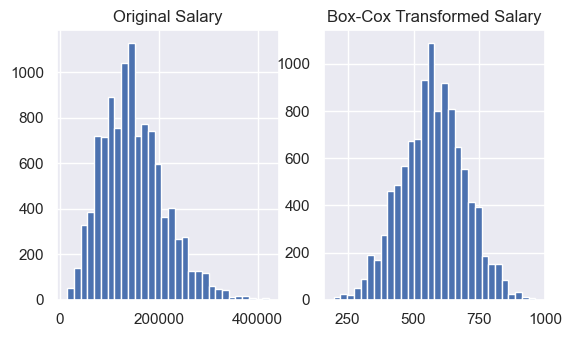

Normal test: NormaltestResult(statistic=3.499892706951689, pvalue=0.17378326606856084)
Kolmogorov-Smirnov test: KstestResult(statistic=1.0, pvalue=0.0, statistic_location=196.87847866902672, statistic_sign=-1)


In [29]:
# fit the lambda and transform the train dependent variable
y_train_original = y_train.copy()
y_train_vals, lmbda = boxcox(y_train)
print(f'Best Lambda Value: {lmbda:.12f}')
y_train = pd.Series(y_train_vals, index=y_train.index, name='transformed_salary')

# transform the test dependent variable

y_test_original = y_test.copy()
y_test_vals = boxcox(y_test, lmbda)
y_test = pd.Series(y_test_vals, index=y_test.index, name='transformed_salary')

# plot

plt.figure(figsize=(6.3, 3.5))

# Original
plt.subplot(1, 2, 1)
plt.hist(y_train_original, bins=30)
plt.title('Original Salary')

# Transformed
plt.subplot(1, 2, 2)
plt.hist(y_train, bins=30)
plt.title('Box-Cox Transformed Salary')

plt.show()

print('Normal test:', normaltest(y_train))
print('Kolmogorov-Smirnov test:', kstest(y_train, "norm"))

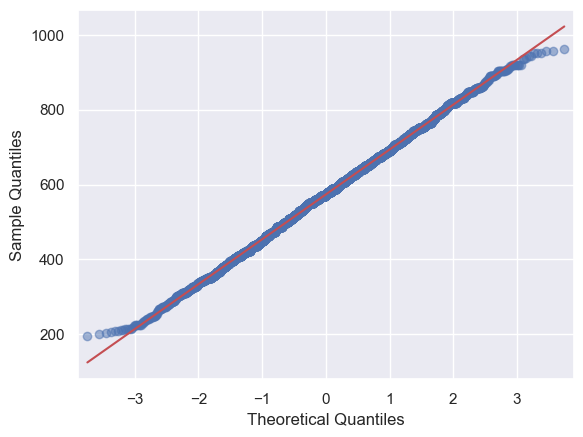

In [30]:
sm.qqplot(y_train, line='s', alpha=0.5)
plt.show()

In [31]:
y_train.describe()

count    10906.000000
mean       573.559235
std        119.889218
min        196.878479
25%        494.701704
50%        573.465432
75%        651.762243
max        961.940203
Name: transformed_salary, dtype: float64

In [32]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Starting the Model

In [33]:
# Create a model and displaying the summary
OLS_model = sm.OLS(y_train, X_train).fit()
OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     76.12
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:07:40   Log-Likelihood:                -64590.
No. Observations:               10906   AIC:                         1.294e+05
Df Residuals:                   10797   BIC:                         1.302e+05
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -8239.4518   2853.654     -2.887      0.004   -1.38e+04   -2645.766
work_year                   4.3428      1.410      3.079      0.002       1.578       7.107
work_abroad                 9.8233     22.791      0.431      0.666     -34.851      54.497
job_name_AI                46.0860      8.202      5.619      0.000      30.008      62.164
job_name_Analyst           -6.1424      7.575     -0.811      0.417     -20.991       8.706
job_name_Analytics         21.9192      5.127      4.276      0.000      11.870      31.968
job_name_Applied           53.6874      6.023      8.914      0.000      41.881      65.493
job_name_Architect         74.8137      9.128      8.196      0.000      56.922      92.706
job_name_Big               16.4542     32.275      0.510      0.610     -46.811      79.719
job_name_Consultant       -80.0474     11.932     -6.709      0.000    -103.436     -56.659
job_name_Database        -156.9611     55.061     -2.851      0.004    -264.891     -49.031
job_name_Decision          11.4246     16.680      0.685      0.493     -21.271      44.120
job_name_Deep              79.8881     27.621      2.892      0.004      25.746     134.030
job_name_Developer         -5.5725     10.879     -0.512      0.609     -26.898      15.753
job_name_Director          78.2412     17.302      4.522      0.000      44.327     112.156
job_name_ETL               -5.7541     22.970     -0.251      0.802     -50.779      39.271
job_name_Head             117.1104     15.723      7.448      0.000      86.290     147.931
job_name_Infrastructure    28.1737     14.673      1.920      0.055      -0.588      56.935
job_name_Insight          -27.4021     34.655     -0.791      0.429     -95.332      40.528
job_name_Integration        1.0712     17.170      0.062      0.950     -32.586      34.728
job_name_Lead              64.1622     11.652      5.506      0.000      41.322      87.003
job_name_NLP               24.0107     28.266      0.849      0.396     -31.396      79.418
job_name_Ops              -28.0126     28.134     -0.996      0.319     -83.160      27.135
job_name_Owner             -2.6301     45.462     -0.058      0.954     -91.744      86.484
job_name_Practitioner     -46.3979     30.326     -1.530      0.126    -105.842      13.046
job_name_Principal         68.8832     26.592      2.590      0.010      16.759     121.008
job_name_Product           64.5217     19.680      3.279      0.001      25.946     103.098
job_name_Prompt            78.5869     28.964      2.713      0.007      21.811     135.363
job_name_Quality          -44.6942     22.130     -2.020      0.043     -88.074      -1.315
job_name_Robotics          13.5845     32.045      0.424      0.672     -49.230      76.399
job_name_Software          50.6843     23.419  

In [34]:
pvalues = OLS_model.pvalues
print('Significant coefficients:', pvalues[pvalues <= 0.05].count())
print('Coefficients NOT significant:', pvalues[pvalues > 0.05].count(), '\n')
print(OLS_model.pvalues.sort_values().to_string())

Significant coefficients: 67
Coefficients NOT significant: 53 

experience_level_EN        9.812122e-141
experience_level_MI        3.230121e-124
job_name_Machine           1.883607e-101
job_name_Research           7.312592e-35
salary_currency_GBP         3.250382e-34
job_name_Scientist          1.038851e-22
job_name_Applied            5.719399e-19
experience_level_EX         3.610440e-17
job_name_Architect          2.756851e-16
job_name_Head               1.017866e-13
job_name_Engineer           2.257389e-13
job_name_Consultant         2.062618e-11
employee_residence_CO       2.796224e-11
company_location_CO         2.796224e-11
salary_currency_EUR         1.647940e-08
job_name_AI                 1.973154e-08
job_name_Lead               3.745486e-08
employee_residence_NG       9.256046e-08
employee_residence_LV       1.246896e-06
company_location_LV         1.246896e-06
company_location_MX         1.944360e-06
employee_residence_MX       1.944360e-06
company_size_S              2.3460

In [35]:
y_pred = OLS_model.predict(X_test)

In [36]:
# Design a function to display standardized information
def create_scatter(model_corr, y_pred, y_test=y_test, X_test=X_test):

    residuals = y_test - y_pred
    comparison_df = pd.DataFrame((y_test, y_pred, residuals)).transpose()
    comparison_df.columns = ["Observed", "Predicted", "Residual"]
    display(comparison_df.describe())

    m, b = np.polyfit(y_test, y_pred, deg=1)
    R_2 = pearsonr(y_test, y_pred)
    
    # Adjusting charts' limits (with a buffer)
    llim = min(y_test.min(), y_pred.min()) - 30
    ulim = max(y_test.max(), y_pred.max()) + 30
    llim = floor(llim/100)*100
    ulim = ceil(ulim/100)*100

    print('Scatter plot of Predicted vs Actual values')

    g = sns.jointplot(x=y_test, y=y_pred, kind="reg", height=6.7, xlim=(llim, ulim), ylim=(llim, ulim), 
                      joint_kws={'scatter_kws':dict(s=15, alpha=.2)}, line_kws=dict(color="r"))

    for i in [400, 700]:
        g.refline(x=i, y=i, linestyle=":", alpha=.5)

    plt.xlabel('Observed y values')
    plt.ylabel('Predicted y values')

    plt.show()

    print(f'Model R squared: {model_corr:.4f}')
    print(f'Prediction R squared: {R_2[0]**2:.4f} p-value: {R_2[1]:.4f}')
    print(f'y = {m:.4f}x {b:+.1f} \n\n')
    
    
    print('RESIDUALS PLOT')
    
    plt.figure(figsize=(6.7, 3.5))
    plt.scatter(y_pred, residuals, s=15, alpha=.2)
    plt.xlabel('Predicted y values')
    plt.ylabel('Residuals')
    plt.show()    
        
    het = sms.het_breuschpagan(residuals, X_test)
    print('Breusch-Pegan Test for Heteroskedasticity:\n',
          'If the test statistic has a p-value below 0.05, the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.\n',
          f'Lagrange multiplier statistic: {het[0]:.4f}, p-value: {het[1]:.4f}\n',
         sep='') 
    if het[1] < 0.05:
        print('Homoskedasticity is rejected.')
    print('\n\n')
    
    # tests and histogram to look at residuals' normality
    print('RESIDUALS NORMALITY')
    print(normaltest(residuals))
    print(kstest(residuals, "norm"))
    print('Residuals Histogram')
    plt.hist(residuals, bins=20)
    plt.xlabel('Residuals')
    plt.ylabel('Amount of instances')
    plt.show()

,Observed,Predicted,Residual
count,3638.000000,3638.000000,3638.000000
mean,574.662719,575.393001,-0.730281
std,118.595406,80.112447,90.840750
min,202.834242,134.741183,-351.760145
25%,497.626500,539.937582,-62.749974
50%,574.230940,599.544789,-5.147132
75%,651.596109,620.893667,57.409735
max,954.368721,783.316286,540.761520


Scatter plot of Predicted vs Actual values


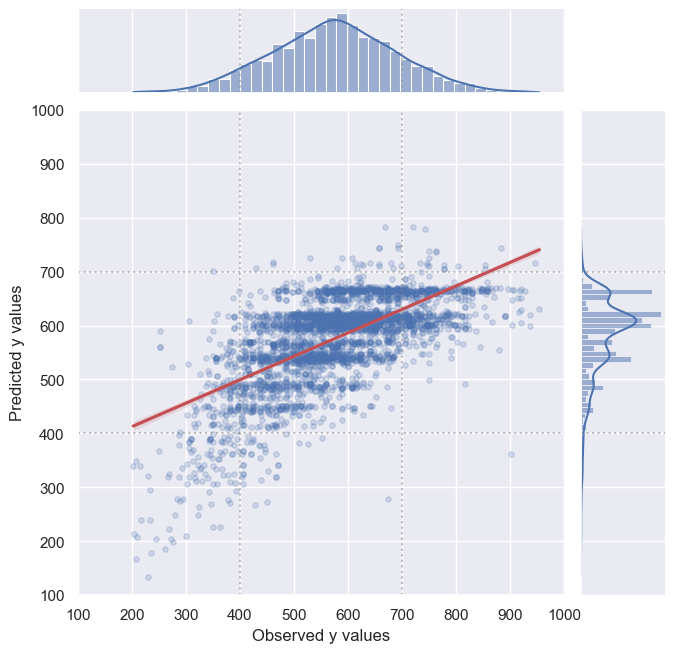

Model R squared: 0.4323
Prediction R squared: 0.4143 p-value: 0.0000
y = 0.4348x +325.5 


RESIDUALS PLOT


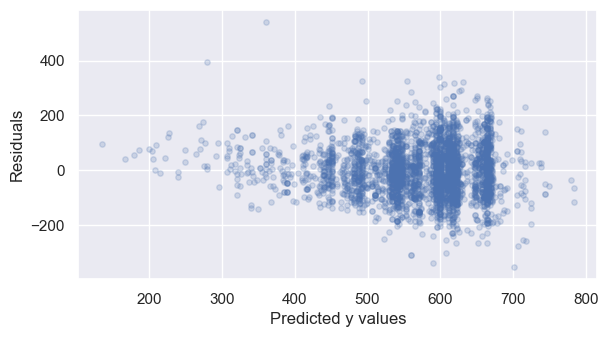

Breusch-Pegan Test for Heteroskedasticity:
If the test statistic has a p-value below 0.05, the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
Lagrange multiplier statistic: 377.7825, p-value: 0.0000

Homoskedasticity is rejected.



RESIDUALS NORMALITY
NormaltestResult(statistic=72.52437707195155, pvalue=1.7845619017754975e-16)
KstestResult(statistic=0.5057443606542213, pvalue=0.0, statistic_location=-3.428988077338772, statistic_sign=1)
Residuals Histogram


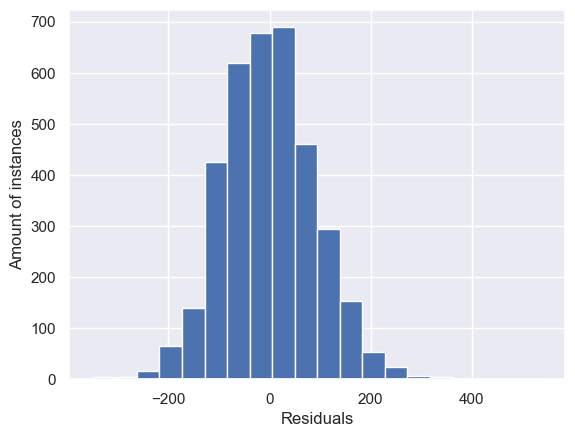

In [37]:
create_scatter(model_corr=OLS_model.rsquared, y_pred=y_pred)

## SIGNIFICANT ONLY

In [38]:
X_train_step = X_train.copy()
X_test_step = X_test.copy()
y_train_step = y_train.copy()
y_test_step = y_test.copy()

In [39]:
# Create a model and displaying the summary

# A few variables look like they still have high p-values even in an isolated model.
# Loop until only significant variables are present
NOT_significant_vars = [1] # creation of a non empty list to enter the loop
while NOT_significant_vars != []:
    # The model is created, but a new one using only the previously resulting significant variables 
    # did not render a new model that had all variables resulting significant.
    # A stepwise deletion for these variables will be done here until that happens.
    OLS_model_step = sm.OLS(y_train_step, X_train_step).fit()
    y_pred_step = OLS_model_step.predict(X_test_step)

    # Bring all not significant variables into a single list
    NOT_significant_vars = OLS_model_step.pvalues[OLS_model_step.pvalues > 0.05]
    NOT_significant_vars = list(NOT_significant_vars.index)

    # remove the intercept from this list so it isn't removed from the model
    if 'const' in NOT_significant_vars:
        NOT_significant_vars.remove('const')

    X_train_step.drop(NOT_significant_vars, axis=1, inplace=True)
    X_test_step.drop(NOT_significant_vars, axis=1, inplace=True)

OLS_model_step.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     154.5
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:07:44   Log-Likelihood:                -64656.
No. Observations:               10906   AIC:                         1.294e+05
Df Residuals:                   10853   BIC:                         1.298e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -9536.3113   2786.803     -3.422      0.001    -1.5e+04   -4073.669
work_year                 4.9806      1.377      3.616      0.000       2.281       7.681
job_name_AI              45.6836      8.112      5.632      0.000      29.783      61.584
job_name_Analytics       20.9986      5.073      4.139      0.000      11.054      30.943
job_name_Applied         54.7750      5.954      9.199      0.000      43.104      66.446
job_name_Architect       81.1974      5.718     14.200      0.000      69.989      92.406
job_name_Consultant     -76.5125     11.890     -6.435      0.000     -99.819     -53.206
job_name_Database      -134.1722     50.120     -2.677      0.007    -232.416     -35.928
job_name_Deep            83.7591     27.674      3.027      0.002      29.513     138.005
job_name_Director        78.0805     17.227      4.532      0.000      44.312     111.849
job_name_Head           115.8121     14.677      7.891      0.000      87.043     144.581
job_name_Lead            67.2000     11.102      6.053      0.000      45.439      88.961
job_name_Principal       74.0622     26.548      2.790      0.005      22.024     126.100
job_name_Product         65.4116     17.688      3.698      0.000      30.740     100.083
job_name_Prompt          81.8061     28.876      2.833      0.005      25.205     138.408
job_name_Quality        -43.9054     22.191     -1.978      0.048     -87.405      -0.406
job_name_Software        48.3357     20.387      2.371      0.018       8.374      88.298
job_name_Vision          58.7301     17.932      3.275      0.001      23.580      93.880
job_name_Machine         63.3017      2.875     22.019      0.000      57.666      68.937
job_name_Operations     -44.5055     12.135     -3.668      0.000     -68.292     -20.719
job_name_Cloud          141.1893     41.009      3.443      0.001      60.803     221.575
job_name_Engineer        60.3179      2.531     23.833      0.000      55.357      65.279
job_name_Research        47.8367      3.814     12.542      0.000      40.360      55.313
job_name_Scientist       77.6882      2.550     30.464      0.000      72.689      82.687
job_name_Manager         20.4904      5.402      3.793      0.000       9.901      31.080
experience_level_EN     -95.5907      3.569    -26.782      0.000    -102.587     -88.594
experience_level_EX      48.3934      5.710      8.476      0.000      37.201      59.586
experience_level_MI     -53.2459      2.165    -24.588      0.000     -57.491     -49.001
employment_type_FL     -116.5030     36.469     -3.195      0.001    -187.988     -45.018
salary_currency_AUD    -129.3976     37.449     -3.455      0.001    -202.805     -55.990
salary_currency_CAD     -87.1712     15.502     -5.623      0.000    -117.557     -56.785
salary_currency_EUR    

In [40]:
y_pred_step = OLS_model_step.predict(X_test_step)

,Observed,Predicted,Residual
count,3638.000000,3638.000000,3638.000000
mean,574.662719,575.479658,-0.816939
std,118.595406,79.387777,91.060581
min,202.834242,149.402312,-337.650059
25%,497.626500,539.363420,-63.394113
50%,574.230940,599.681349,-4.717435
75%,651.596109,620.560812,56.553323
max,954.368721,781.257067,541.151302


Scatter plot of Predicted vs Actual values


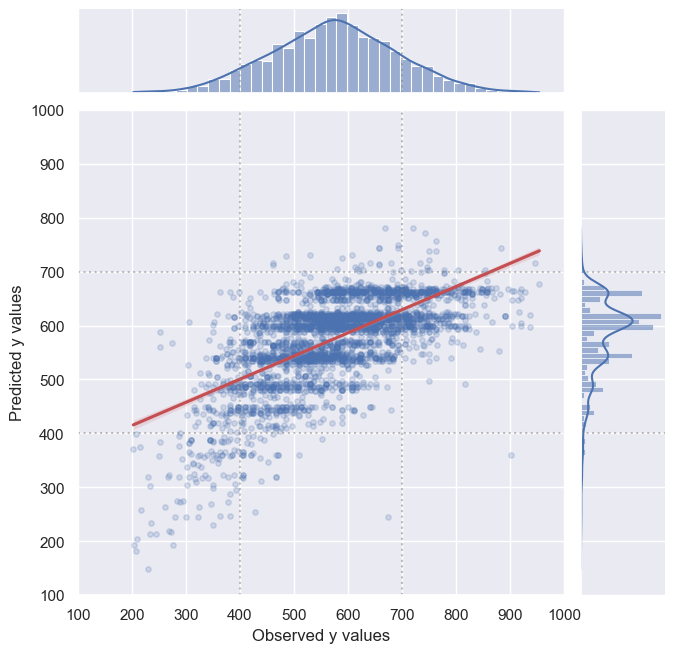

Model R squared: 0.4254
Prediction R squared: 0.4112 p-value: 0.0000
y = 0.4293x +328.8 


RESIDUALS PLOT


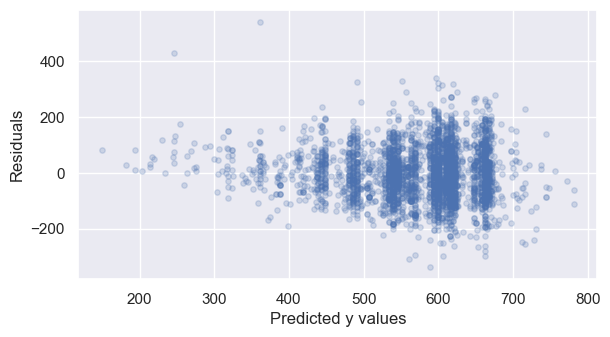

Breusch-Pegan Test for Heteroskedasticity:
If the test statistic has a p-value below 0.05, the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
Lagrange multiplier statistic: 199.9127, p-value: 0.0000

Homoskedasticity is rejected.



RESIDUALS NORMALITY
NormaltestResult(statistic=74.63061642332335, pvalue=6.225404182988434e-17)
KstestResult(statistic=0.5058827583407755, pvalue=0.0, statistic_location=-3.3267050482821787, statistic_sign=1)
Residuals Histogram


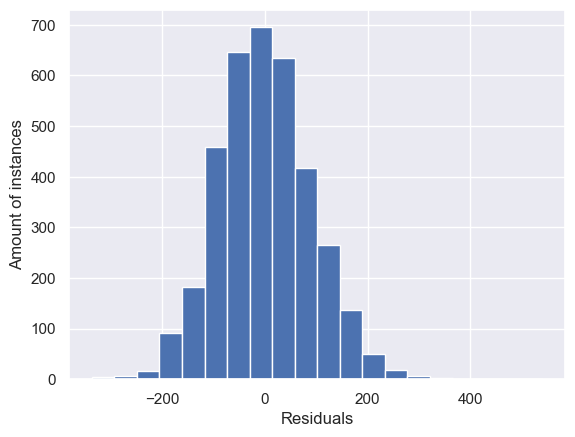

In [41]:
create_scatter(model_corr=OLS_model_step.rsquared, y_pred=y_pred_step, y_test=y_test_step, X_test=X_test_step)

# Neural Network

In [42]:
# Create a model and displaying the summary
NN_model = MLPRegressor((X_train.shape[1],X_train.shape[1],X_train.shape[1]), max_iter=20000, random_state=42)
NN_model = NN_model.fit(X_train, y_train)
# after a few iterations with nodes and depths, this was consistently the best performing model
y_pred_nn = NN_model.predict(X_test)

,Observed,Predicted,Residual
count,3638.000000,916.000000,3638.000000
mean,574.662719,587.749237,-9.415637
std,118.595406,71.899942,90.711562
min,202.834242,252.646490,-354.619544
25%,497.626500,551.396396,-71.336597
50%,574.230940,613.414714,-14.795428
75%,651.596109,630.951824,48.091639
max,954.368721,723.429583,514.401034


Scatter plot of Predicted vs Actual values


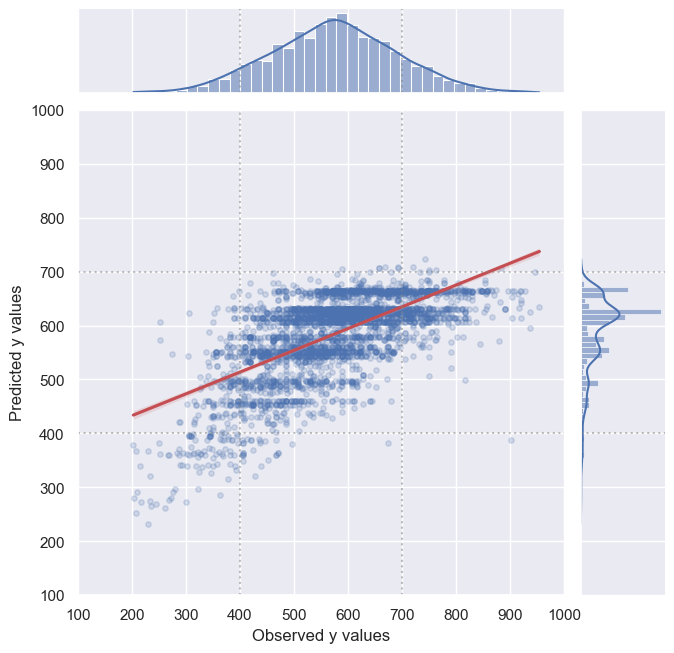

Model R squared: 0.4086
Prediction R squared: 0.4153 p-value: 0.0000
y = 0.4036x +352.1 


RESIDUALS PLOT


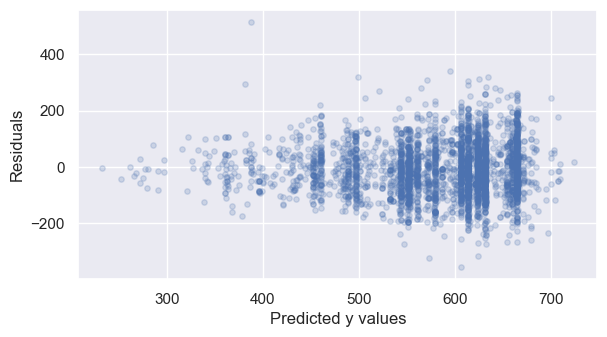

Breusch-Pegan Test for Heteroskedasticity:
If the test statistic has a p-value below 0.05, the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
Lagrange multiplier statistic: 221.1136, p-value: 0.0000

Homoskedasticity is rejected.



RESIDUALS NORMALITY
NormaltestResult(statistic=75.39710749589707, pvalue=4.2435188094515286e-17)
KstestResult(statistic=0.5456043064730883, pvalue=0.0, statistic_location=-2.933759465644698, statistic_sign=1)
Residuals Histogram


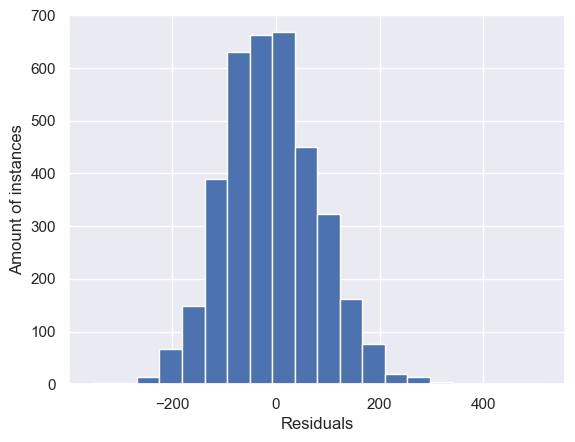

In [43]:
create_scatter(model_corr=NN_model.score(X_test, y_test), y_pred=y_pred_nn)

# PCA

In [44]:
X_train = X_train.drop('const', axis=1)
X_test = X_test.drop('const', axis=1)

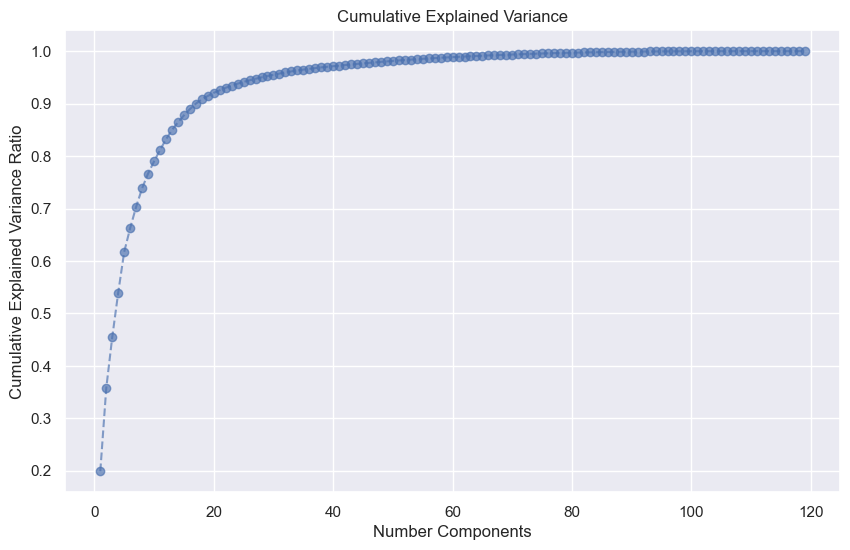

In [45]:
pca = PCA(n_components=X_train.shape[1]).fit(X_train) # fitted on train base only
X_pca_train = pca.transform(X_train) # Transforming train base
X_pca_test = pca.transform(X_test)   # Transforming test base

# Variance explained by each principal component
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, X_pca_train.shape[1] + 1), cumulative_variance_ratio, marker='o', linestyle='--', alpha=0.67)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [46]:
# Print the explained variance ratio for each component

pca_variance = pd.DataFrame({
    'Variance': pca.explained_variance_ratio_,
    'Cumulative Variance': pca.explained_variance_ratio_.cumsum(),
    'Eigenvalue': pca.singular_values_
    })
pca_variance['Component'] = pca_variance.index +1

pca_variance['Component'] = 'PC' + pca_variance['Component'].astype(str)
print(pca_variance[pca_variance.Eigenvalue >= 1].to_string())
print(pca_variance[pca_variance.Eigenvalue < 1].to_string())

    Variance  Cumulative Variance  Eigenvalue Component
0   0.199164             0.199164   72.641439       PC1
1   0.158646             0.357810   64.832735       PC2
2   0.096831             0.454641   50.650838       PC3
3   0.084963             0.539604   47.445369       PC4
4   0.077538             0.617141   45.324838       PC5
5   0.045414             0.662556   34.687614       PC6
6   0.040677             0.703232   32.828581       PC7
7   0.035329             0.738561   30.594706       PC8
8   0.028050             0.766612   27.261374       PC9
9   0.023161             0.789773   24.771948      PC10
10  0.021759             0.811532   24.010285      PC11
11  0.020297             0.831829   23.189929      PC12
12  0.017863             0.849692   21.754665      PC13
13  0.014609             0.864301   19.673776      PC14
14  0.013156             0.877457   18.670178      PC15
15  0.011949             0.889406   17.793087      PC16
16  0.010500             0.899906   16.678793   

In [47]:
components_df = pd.DataFrame(pca.components_, columns=X_train.columns).set_index(pca_variance['Component'])
components_df

,work_year,work_abroad,job_name_AI,job_name_Analyst,job_name_Analytics,job_name_Applied,job_name_Architect,job_name_Big,job_name_Consultant,job_name_Database,...,company_location_NG,company_location_NL,company_location_PH,company_location_PL,company_location_PT,company_location_SI,company_location_UA,company_location_ZA,company_size_L,company_size_S
Component,,,,,,,,,,,,,,,,,,,,,
PC1,-0.971923,1.208493e-02,-4.526160e-03,-4.570634e-03,4.928142e-04,2.119459e-03,9.131898e-04,2.020944e-03,-4.308972e-04,-9.300338e-04,...,5.617867e-04,2.593564e-03,7.236653e-05,1.646145e-03,2.219621e-03,0.000918,-0.000293,-0.001186,7.457605e-02,2.083219e-02
PC2,0.010950,-1.386465e-03,7.898733e-03,-1.250866e-01,4.433732e-02,-5.707204e-02,-9.954040e-03,9.202181e-04,-9.526090e-03,1.451418e-03,...,-1.506729e-04,-6.117559e-04,-2.449245e-04,1.381320e-05,7.129967e-04,0.000140,0.000642,0.000672,-3.549319e-02,-2.204862e-03
PC3,0.042771,8.917340e-04,-3.376207e-03,6.964031e-01,-3.026604e-03,-5.641871e-02,2.523669e-02,5.931657e-04,-8.413731e-03,-1.115224e-05,...,7.111774e-04,-4.775380e-04,1.168074e-03,4.483018e-04,1.617585e-05,0.000468,-0.000254,0.000481,-6.649653e-02,3.786685e-03
PC4,-0.194898,-3.037935e-03,-1.397933e-03,2.036965e-01,-1.580801e-02,-1.193474e-02,-2.212209e-02,9.391525e-04,1.056727e-03,-1.128088e-03,...,-1.763892e-04,1.358424e-03,8.617136e-04,-2.227753e-03,1.029213e-03,0.000946,-0.000669,0.001257,5.866251e-02,-1.640375e-03
PC5,0.032594,4.848837e-03,4.595933e-03,-1.118609e-01,2.843843e-02,-1.102435e-04,-1.788427e-02,8.877359e-04,-6.096774e-04,2.349928e-03,...,-1.200466e-04,1.737742e-03,9.482307e-05,2.337350e-03,1.408472e-03,0.001151,-0.000941,-0.000326,1.474827e-02,8.238066e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC115,-0.000000,2.272054e-18,4.951878e-18,3.892975e-17,1.517945e-17,-1.011825e-17,3.581655e-17,-6.847663e-17,3.005148e-17,1.942597e-17,...,2.055997e-16,1.634866e-16,4.234494e-16,-4.692870e-17,4.351366e-17,-0.075799,0.340163,0.068239,1.079409e-17,2.263487e-17
PC116,-0.000000,-9.200676e-18,1.640606e-17,1.287159e-17,-8.762451e-18,-1.857598e-17,2.027919e-17,-1.035506e-16,2.273342e-18,5.388480e-17,...,2.172843e-16,-3.729486e-17,3.347653e-17,-1.159114e-16,9.105549e-17,0.039460,-0.083793,0.081213,6.962769e-18,-1.720156e-17
PC117,-0.000000,-1.935253e-17,-7.024140e-18,-1.625822e-17,-4.528747e-18,-8.648462e-18,-1.733179e-17,4.965218e-17,1.967545e-17,-2.006887e-16,...,-1.384872e-16,7.796654e-17,-3.436212e-17,-4.554874e-17,-1.677238e-16,0.002023,-0.573506,0.026717,3.800225e-18,-7.359348e-18


In [48]:
# How many components have Eigenvalues larger than 1?
Eigen1 = pca_variance[pca_variance.Eigenvalue >= 1].shape[0]
Eigen1

99

In [49]:
pca_variance['Labels'] = pca_variance['Component'] + ":\n" + (pca_variance['Cumulative Variance']*100).round(1).astype(str) + '%'
pca_variance.tail(20)

,Variance,Cumulative Variance,Eigenvalue,Component,Labels
99,3.261954e-05,0.999838,9.296475e-01,PC100,PC100:\n100.0%
100,3.102301e-05,0.999869,9.066118e-01,PC101,PC101:\n100.0%
101,2.679793e-05,0.999895,8.426167e-01,PC102,PC102:\n100.0%
102,2.309539e-05,0.999918,7.822437e-01,PC103,PC103:\n100.0%
103,2.151815e-05,0.999940,7.550607e-01,PC104,PC104:\n100.0%
104,1.857632e-05,0.999959,7.015511e-01,PC105,PC105:\n100.0%
105,1.642790e-05,0.999975,6.597364e-01,PC106,PC106:\n100.0%
106,1.381423e-05,0.999989,6.049825e-01,PC107,PC107:\n100.0%
107,1.117149e-05,1.000000,5.440452e-01,PC108,PC108:\n100.0%
108,3.927810e-32,1.000000,3.225928e-14,PC109,PC109:\n100.0%


## Creating a PCA visualization plot
The main reason here is to understand each component's relation to the original variables

In [50]:
# Set cumulative variance milestones for the chart
reference_y_values = [.90, .95, .975, .99, .995, .999]
y_ticks = []
for val in reference_y_values:
    aux = pca_variance[pca_variance['Cumulative Variance'] > val]
    aux = aux.iloc[0, :]
    y_ticks.append(aux.name)
y_ticks

[17, 27, 43, 62, 73, 89]

In [51]:
# Count independent variables in categories to ease visualization
aux = []
for col in X_train.columns:
    aux.append(col[:9])
unique_entries = {}
for entry in set(aux):
    unique_entries[entry] = 0
for entry in aux:
    unique_entries[entry] = unique_entries[entry] + 1
unique_entries

{'employee_': 28,
 'salary_cu': 7,
 'remote_ra': 2,
 'company_s': 2,
 'company_l': 28,
 'employmen': 3,
 'work_year': 1,
 'work_abro': 1,
 'experienc': 3,
 'job_name_': 44}

In [52]:
# Set the limit for each new variables' category
limit_x_values = [1, 2, unique_entries['job_name_'] + 2]
for aux in ['experienc', 'employmen', 'salary_cu', 'employee_', 'remote_ra', 'company_l', 'company_s']:
    limit_x_values.append(max(limit_x_values) + unique_entries[aux])
del limit_x_values[-1:] #removing the last value as it's out of bounds for the DataFrame
print(limit_x_values)
[X_train.columns[i] for i in limit_x_values]

[1, 2, 46, 49, 52, 59, 87, 89, 117]


['work_abroad',
 'job_name_AI',
 'experience_level_EN',
 'employment_type_CT',
 'salary_currency_AUD',
 'employee_residence_AR',
 'remote_ratio_Hybrid',
 'company_location_AR',
 'company_size_L']

In [53]:
# based on the variable limits, position the ticks for a few variables for readability
xticks = [1, # work abroad
 round((limit_x_values[1] + limit_x_values[2])/2), # Job title in the middle
 limit_x_values[2],            # Experience level on one corner (will overlap with employment type, so that'll be skipped)
 limit_x_values[5]-1,                              # Currency on the other corner
 round((limit_x_values[5] + limit_x_values[7])/2), # Employee residence (middle)
 limit_x_values[7]-1,                              # Remote Ratio (middle)
 round(sum(limit_x_values[7:9])/2),                # Company Location (middle)
 limit_x_values[8]]                                # Company Size (middle)
[X_train.columns[i] for i in xticks]               # Review which variables will show

['work_abroad',
 'job_name_Principal',
 'experience_level_EN',
 'salary_currency_PLN',
 'employee_residence_IN',
 'remote_ratio_Remote',
 'company_location_IE',
 'company_size_L']

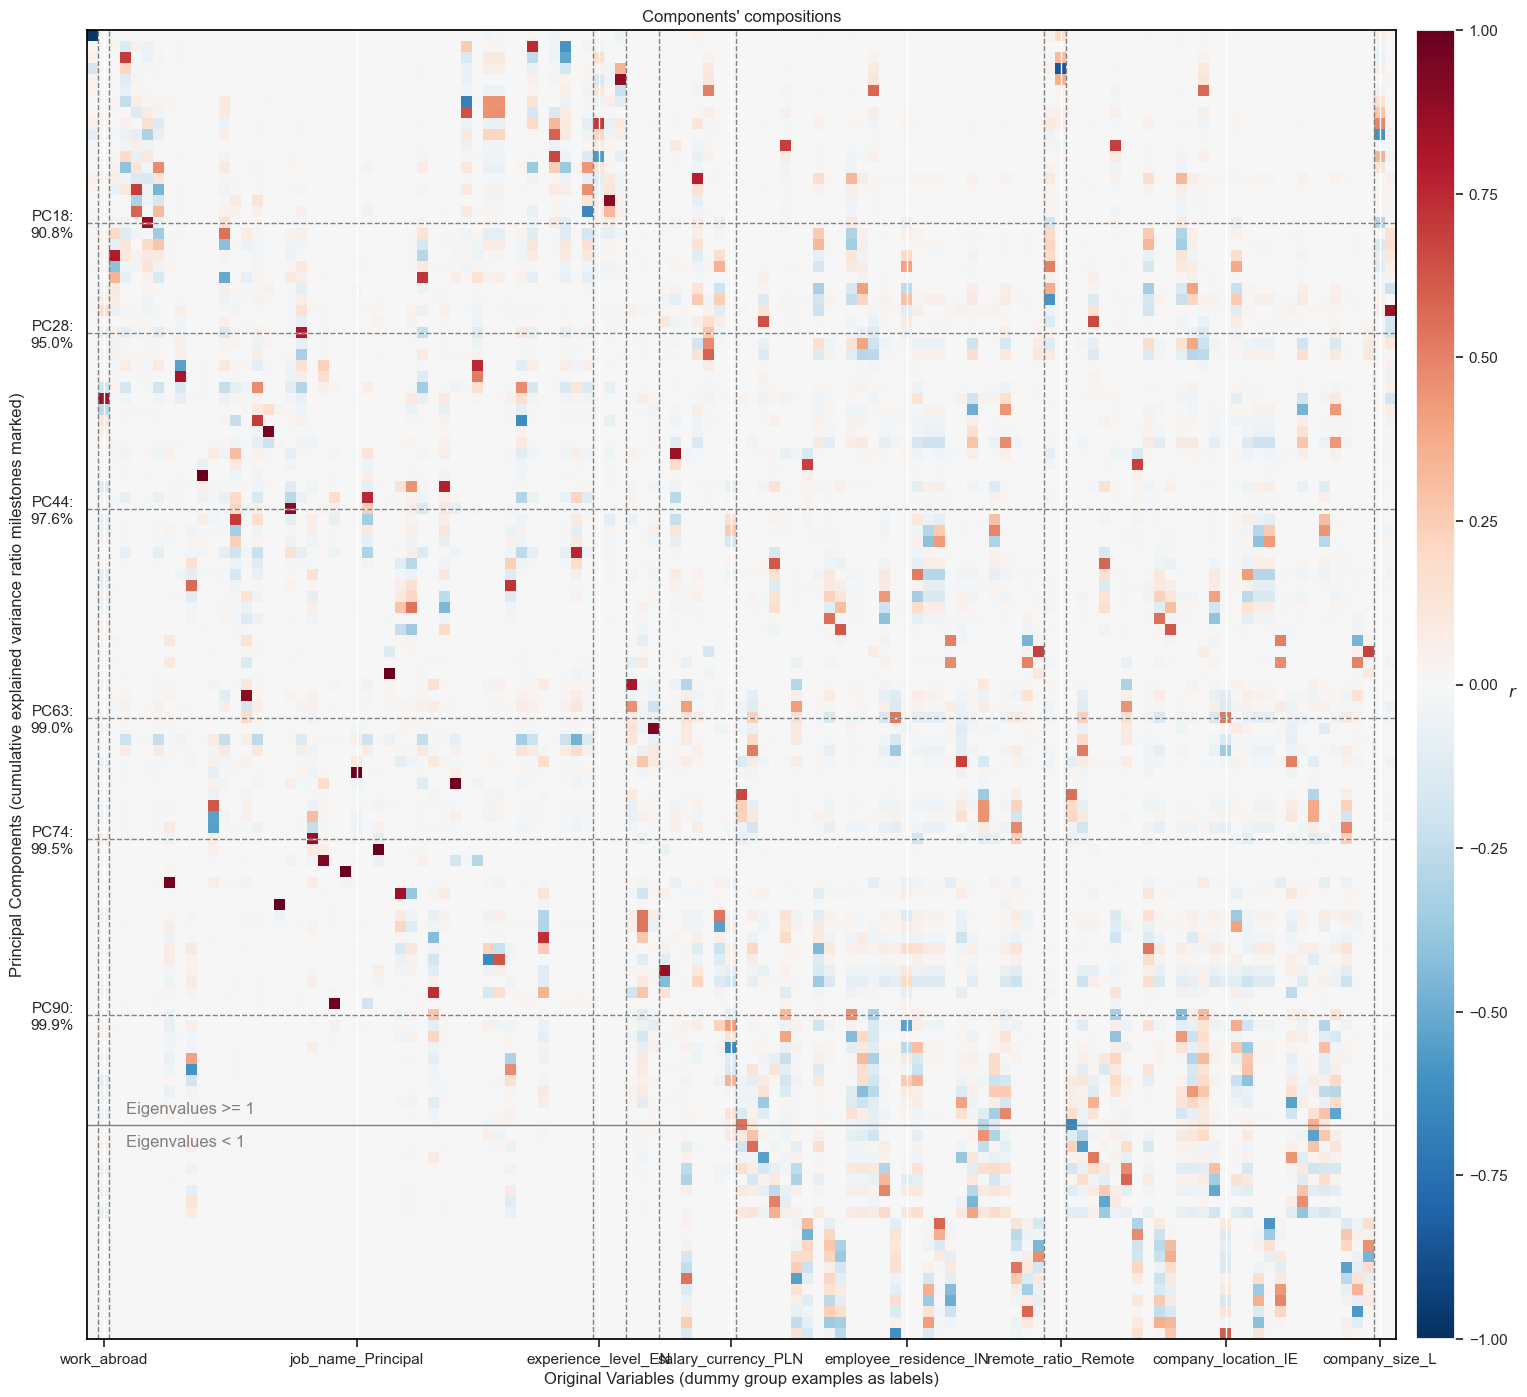

In [54]:
# Components' compositions heat matrix plot

fig, ax = plt.subplots(figsize=(18, 17))
im = ax.imshow(components_df, cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_title("Components' compositions")
plt.xlabel('Original Variables (dummy group examples as labels)')
plt.ylabel('Principal Components (cumulative explained variance ratio milestones marked)')

ax.tick_params(left=False, right=False, top=False, reset=True)
ax.set_xticks(xticks)
ax.set_xticklabels(components_df.columns[xticks])
for x_value in limit_x_values:
    plt.axvline(x=x_value-0.5, color='gray', linestyle='--', linewidth=1)

ax.set_yticks(y_ticks)
ax.set_yticklabels(pca_variance['Labels'][y_ticks])
for y_value in y_ticks:
    plt.axhline(y=y_value, color='gray', linestyle='--', linewidth=1)
    
plt.axhline(y=Eigen1, color='gray', linestyle='-', linewidth=1)
plt.annotate('Eigenvalues >= 1', xy=(0, Eigen1), xytext=(3, Eigen1-1), color="gray", size=12)
plt.annotate('Eigenvalues < 1', xy=(0, Eigen1), xytext=(3, Eigen1+2), color="gray", size=12)

cax = make_axes_locatable(ax).append_axes("right", size="3%", pad=0.2)
plt.colorbar(im, cax=cax).ax.set_ylabel("$r$", rotation=0)

[a.set_color("black") for a in ax.spines.values()]

plt.show()

In [55]:
# The naming used here is X_pca will be the original array and X_train_pca will be the dataframe derived from it
X_train_pca = pd.DataFrame(X_pca_train, columns = pca_variance['Component'].to_list())
X_train_pca.set_index(X_train.index, inplace=True)
X_train_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119
1694,-0.944019,-0.734627,-0.441110,0.221216,0.618804,-0.175338,-0.108818,-0.026812,-0.012910,0.015803,...,-4.124337e-18,2.578926e-18,1.027132e-17,6.036805e-18,6.890343e-19,-3.652618e-18,-2.285571e-18,-2.946900e-18,8.398353e-19,4.684970e-18
9814,0.286095,0.587454,0.088567,-0.309484,0.973315,-0.244793,0.078742,-0.210346,0.242544,0.022436,...,-2.060421e-17,9.734660e-18,1.037974e-17,-1.618934e-17,9.091601e-18,-5.495761e-18,-9.845287e-19,-2.316727e-17,2.899819e-18,9.916246e-18
2372,-0.957848,0.559631,-0.223828,0.348844,0.599559,-0.211877,0.076733,-0.409563,0.399800,0.531474,...,-3.473816e-18,-3.275766e-18,9.295539e-18,-1.055149e-17,-9.610886e-18,-9.724150e-18,-1.442864e-17,-9.994215e-18,-6.641160e-18,-2.037083e-18
12314,0.096467,0.870206,-0.364039,0.118388,-0.358157,-0.044116,-0.483948,0.355339,-0.112773,0.050485,...,-1.305412e-18,-5.552591e-18,-4.148568e-18,1.754206e-18,-4.569346e-18,-1.701054e-18,-1.851890e-18,3.449892e-18,1.815617e-18,3.481617e-19
7319,0.056282,-0.767589,-0.526622,0.087826,-0.326463,0.020854,0.002311,-0.191540,0.168964,0.617418,...,-1.196991e-18,-1.021466e-17,4.633470e-18,-1.141885e-17,-1.139982e-17,-1.701054e-18,-5.538178e-18,-1.971118e-18,-1.111729e-18,2.679196e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,0.294650,0.620789,0.094100,-0.692483,0.034144,0.041375,0.258241,-0.250006,-0.076235,-0.074273,...,1.181343e-17,2.904186e-18,-1.228008e-17,-1.281560e-18,1.830732e-17,1.423672e-17,4.870163e-18,8.111962e-18,9.730293e-18,4.023718e-19
13418,1.012134,0.580781,-0.260322,0.721936,0.562350,-0.266744,0.067821,-0.293608,-0.007772,0.100676,...,-4.232757e-18,4.096809e-18,6.042933e-18,3.217879e-18,-4.493780e-19,-5.495761e-18,-6.188699e-18,-3.272161e-18,-2.195931e-18,-1.928663e-18
5390,0.040211,0.591731,-0.217551,0.527038,0.594944,-0.239618,0.072554,-0.277708,0.034362,0.022004,...,-4.232757e-18,4.096809e-18,6.042933e-18,3.217879e-18,-4.493780e-19,-5.495761e-18,-6.188699e-18,-3.272161e-18,-2.195931e-18,-1.928663e-18
860,-0.673835,0.885484,-0.006712,-0.926927,0.028635,0.019495,-0.461207,0.419017,-0.005604,-0.014821,...,3.208917e-19,-2.950505e-18,-2.847525e-18,8.868447e-19,-1.967261e-18,-3.544197e-18,-1.201369e-18,1.823589e-18,2.357718e-18,-5.192001e-19


In [56]:
X_train_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119
count,1.090600e+04,1.090600e+04,1.090600e+04,1.090600e+04,1.090600e+04,1.090600e+04,1.090600e+04,1.090600e+04,1.090600e+04,1.090600e+04,...,1.090600e+04,1.090600e+04,1.090600e+04,1.090600e+04,1.090600e+04,1.090600e+04,1.090600e+04,1.090600e+04,1.090600e+04,1.090600e+04
mean,-3.168580e-14,4.805741e-16,1.485781e-15,-6.330287e-15,1.112463e-15,8.883413e-16,1.667880e-16,5.842465e-16,1.394732e-15,-2.559763e-15,...,-5.452078e-20,-1.097920e-19,-7.339616e-20,-2.246063e-19,1.383109e-20,1.499849e-20,1.960079e-19,-3.808156e-20,2.752624e-20,2.924447e-20
std,6.956193e-01,6.208426e-01,4.850358e-01,4.543400e-01,4.340337e-01,3.321709e-01,3.143687e-01,2.929769e-01,2.610567e-01,2.372178e-01,...,2.873166e-17,3.003190e-17,2.712956e-17,2.822751e-17,3.275928e-17,2.334565e-17,2.567756e-17,1.804881e-17,2.384206e-17,2.880398e-17
min,-1.003397e+00,-8.742376e-01,-8.865735e-01,-1.037850e+00,-6.942450e-01,-5.632499e-01,-7.998184e-01,-4.424355e-01,-5.329024e-01,-9.561632e-01,...,-3.731325e-16,-3.598949e-16,-4.655222e-16,-4.167630e-16,-6.108010e-16,-4.389598e-16,-3.026807e-16,-3.071740e-16,-3.720365e-16,-6.168464e-16
25%,-7.012899e-01,-7.202117e-01,-3.640389e-01,-3.850405e-01,-3.060631e-01,-1.327653e-01,-1.728008e-01,-2.183233e-01,-1.468010e-01,-1.000513e-01,...,-2.498034e-18,-2.950505e-18,-4.148568e-18,-5.226182e-19,-3.376724e-18,-3.652618e-18,-4.887657e-18,-3.272161e-18,-2.195931e-18,-3.826017e-18
50%,8.241811e-02,-1.622726e-01,-1.684731e-01,8.850530e-02,-2.287179e-01,-1.691498e-02,7.599311e-03,-6.104221e-02,-6.493366e-02,-1.965890e-02,...,-1.305412e-18,-6.454542e-19,-1.546482e-18,1.537366e-18,-7.746387e-19,-1.050532e-18,-1.069074e-18,1.173068e-18,9.482555e-19,-6.547253e-19
75%,2.727222e-01,6.127669e-01,1.397753e-01,2.960084e-01,1.099733e-01,2.023902e-02,1.842376e-01,4.825916e-02,3.436240e-02,5.048497e-02,...,2.380876e-18,3.012606e-18,4.741890e-18,3.217879e-18,7.302668e-18,2.635755e-18,3.569120e-18,4.534095e-18,3.550341e-18,2.787617e-18
max,3.322931e+00,9.029434e-01,1.438345e+00,1.548260e+00,1.359178e+00,1.814338e+00,1.262808e+00,1.301893e+00,1.654983e+00,9.665338e-01,...,3.584329e-16,6.133641e-16,3.580398e-16,3.910490e-16,4.700627e-16,4.198368e-16,5.247554e-16,2.915821e-16,4.932756e-16,4.527857e-16


In [57]:
#Applying the same transformation to the test base
X_test_pca = pd.DataFrame(X_pca_test, columns = pca_variance['Component'].to_list())
X_test_pca.set_index(X_test.index, inplace=True)

# PCA Model

### Only those with eigenvalues > 1 are selected

In [58]:
components = X_train_pca.columns[:Eigen1]
X_train_eigen1 = X_train_pca[components]
X_train_eigen1 = sm.add_constant(X_train_eigen1)
X_test_eigen1 = X_test_pca[components]
X_test_eigen1 = sm.add_constant(X_test_eigen1)

In [59]:
# Create a model with PCA cols
OLS_model_PCA = sm.OLS(y_train, X_train_eigen1).fit()
OLS_model_PCA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     82.81
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:08:09   Log-Likelihood:                -64598.
No. Observations:               10906   AIC:                         1.294e+05
Df Residuals:                   10806   BIC:                         1.301e+05
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        573.5592      0.870    659.544      0.000     571.855     575.264
PC1          -12.4535      1.250     -9.961      0.000     -14.904     -10.003
PC2           16.4392      1.401     11.736      0.000      13.693      19.185
PC3          -88.5837      1.793    -49.405      0.000     -92.098     -85.069
PC4          -56.1607      1.914    -29.340      0.000     -59.913     -52.409
PC5          -55.7161      2.004    -27.807      0.000     -59.644     -51.788
PC6          -45.8435      2.618    -17.510      0.000     -50.976     -40.711
PC7          -19.0969      2.766     -6.903      0.000     -24.520     -13.674
PC8            4.7616      2.968      1.604      0.109      -1.057      10.580
PC9          -84.0411      3.331    -25.227      0.000     -90.571     -77.511
PC10          -0.8755      3.666     -0.239      0.811      -8.062       6.311
PC11         -23.3313      3.782     -6.168      0.000     -30.746     -15.917
PC12          93.0416      3.916     23.758      0.000      85.365     100.718
PC13          12.8521      4.175      3.079      0.002       4.669      21.035
PC14        -131.7680      4.616    -28.545      0.000    -140.816    -122.719
PC15         -14.3957      4.864     -2.959      0.003     -23.931      -4.861
PC16          48.1749      5.104      9.439      0.000      38.170      58.180
PC17          49.6219      5.445      9.113      0.000      38.949      60.295
PC18          35.3528      6.140      5.757      0.000      23.317      47.389
PC19         -47.6088      6.998     -6.803      0.000     -61.327     -33.891
PC20          51.5875      7.198      7.167      0.000      37.479      65.696
PC21          12.0513      7.998      1.507      0.132      -3.625      27.728
PC22        -137.4237      8.092    -16.983      0.000    -153.286    -121.562
PC23          -9.6420      8.815     -1.094      0.274     -26.922       7.638
PC24          40.7039      8.981      4.532      0.000      23.100      58.308
PC25         -73.6063      9.581     -7.683      0.000     -92.387     -54.826
PC26         -48.7137      9.985     -4.879      0.000     -68.286     -29.141
PC27         -26.5589     10.490     -2.532      0.011     -47.121      -5.997
PC28          36.4318     10.760      3.386      0.001      15.340      57.524
PC29         -41.3499     11.075     -3.734      0.000     -63.059     -19.641
PC30        -129.4066     11.234    -11.520      0.000    -151.427    -107.386
PC31          10.5181     11.769      0.894      0.371     -12.551      33.587
PC32         -76.7608     11.849     -6.478      0.000     -99.986     -53.535
PC33          22.2492     12.717      1.749      0.080      -2.679      47.178
PC34         -31.4222     13.202     -2.380      0.017     -57.301      -5.543
PC35         -34.9749     13.754     -2.543      0.011     -61.936      -8.014
PC

In [60]:
y_pred_eigen1 = OLS_model_PCA.predict(X_test_eigen1)

,Observed,Predicted,Residual
count,3638.000000,3638.000000,3638.000000
mean,574.662719,575.373605,-0.710886
std,118.595406,79.972922,90.677960
min,202.834242,136.549312,-338.787913
25%,497.626500,540.070036,-63.029185
50%,574.230940,599.253099,-5.112221
75%,651.596109,620.843704,57.025384
max,954.368721,783.414004,540.845722


Scatter plot of Predicted vs Actual values


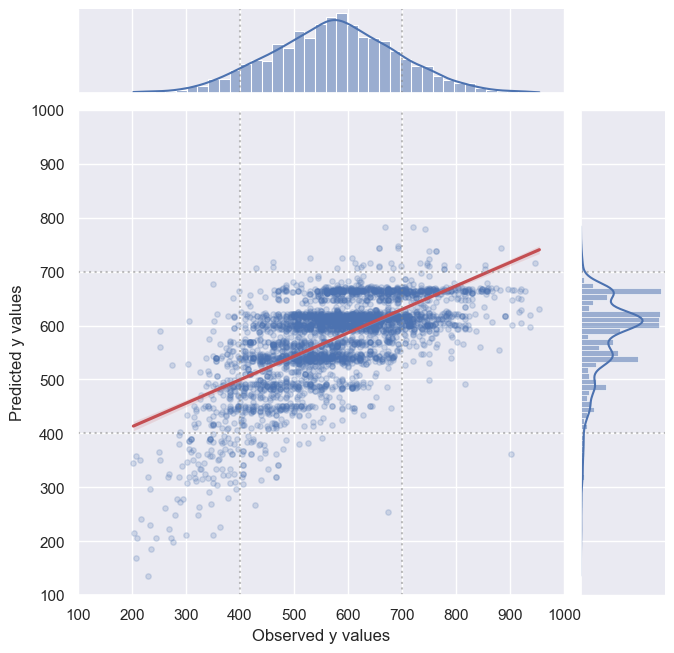

Model R squared: 0.4314
Prediction R squared: 0.4162 p-value: 0.0000
y = 0.4351x +325.4 


RESIDUALS PLOT


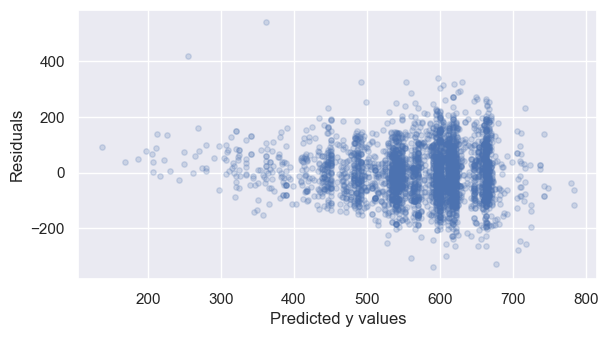

Breusch-Pegan Test for Heteroskedasticity:
If the test statistic has a p-value below 0.05, the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
Lagrange multiplier statistic: 330.4510, p-value: 0.0000

Homoskedasticity is rejected.



RESIDUALS NORMALITY
NormaltestResult(statistic=77.55855865056796, pvalue=1.4400347649383594e-17)
KstestResult(statistic=0.5052546762894329, pvalue=0.0, statistic_location=-3.488521561362404, statistic_sign=1)
Residuals Histogram


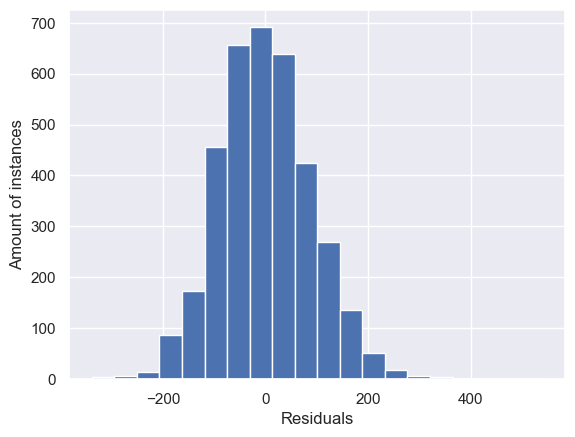

In [61]:
create_scatter(model_corr=OLS_model_PCA.rsquared, y_pred=y_pred_eigen1, X_test=X_test_eigen1)

## HETEROSKEDASTICITY-CONSISTENT STANDARD ERRORS
AKA Robust Standard Errors

In [62]:
# adding once more the constants that were dropped for PCA
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [63]:
# There are four options for HETEROSKEDASTICITY-CONSISTENT STANDARD ERRORS (HCSE) in statsmodels, from zero to three.
# A comparison for all using a significant-only approach will be used:

X_train_HC = {}
X_test_HC = {}
y_train_HC = {}
y_test_HC = {}

for hc in ['HC0', 'HC1', 'HC2', 'HC3']:
    X_train_HC[hc] = X_train.copy()
    X_test_HC[hc] = X_test.copy()
    y_train_HC[hc] = y_train.copy()
    y_test_HC[hc] = y_test.copy()

In [64]:
# Create a model using Significant Only method
OLS_model_HC = {}
y_pred_HC = {}
for hc in ['HC0', 'HC1', 'HC2', 'HC3']:
    # A few variables look like they still have high p-values even in an isolated model.
    # Loop until only significant variables are present
    NOT_significant_vars = [1] # creation of a non empty list to enter the loop
    while NOT_significant_vars != []:
        # The model is created, but a new one using only the previously resulting significant variables 
        # did not render a new model that had all variables resulting significant.
        # A stepwise deletion for these variables will be done here until that happens.
        OLS_model_HC[hc] = sm.OLS(y_train_HC[hc], X_train_HC[hc]).fit(cov_type=hc)
        
        # Bring all not significant variables into a single list
        NOT_significant_vars = OLS_model_HC[hc].pvalues[OLS_model_HC[hc].pvalues > 0.05]
        NOT_significant_vars = list(NOT_significant_vars.index)

        # remove the intercept from this list so it isn't removed from the model
        if 'const' in NOT_significant_vars:
            NOT_significant_vars.remove('const')

        X_train_HC[hc].drop(NOT_significant_vars, axis=1, inplace=True)
        X_test_HC[hc].drop(NOT_significant_vars, axis=1, inplace=True)

    y_pred_HC[hc] = OLS_model_HC[hc].predict(X_test_HC[hc])

### HC0

HC0


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 63, but rank is 56
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     1173.
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:08:13   Log-Likelihood:                -64664.
No. Observations:               10906   AIC:                         1.294e+05
Df Residuals:                   10849   BIC:                         1.299e+05
Df Model:                          56                                         
Covariance Type:                  HC0                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -9588.4957   2809.262     -3.413      0.001   -1.51e+04   -4082.444
work_year                 5.0063      1.389      3.605      0.000       2.285       7.728
job_name_AI              44.2020     10.836      4.079      0.000      22.964      65.441
job_name_Analytics       20.7852      5.131      4.051      0.000      10.728      30.842
job_name_Applied         55.0404      5.534      9.946      0.000      44.194      65.886
job_name_Architect       81.6433      6.044     13.509      0.000      69.798      93.489
job_name_Consultant     -76.3116      8.065     -9.463      0.000     -92.118     -60.505
job_name_Database      -134.7724     50.991     -2.643      0.008    -234.713     -34.832
job_name_Deep            83.1403     35.386      2.350      0.019      13.785     152.496
job_name_Director        75.9049     18.469      4.110      0.000      39.707     112.103
job_name_Head           115.6713     14.346      8.063      0.000      87.555     143.788
job_name_Lead            66.7610     14.080      4.741      0.000      39.164      94.358
job_name_Principal       73.0574     14.476      5.047      0.000      44.685     101.430
job_name_Product         65.7074     13.199      4.978      0.000      39.837      91.578
job_name_Prompt          78.4985     26.954      2.912      0.004      25.669     131.328
job_name_Quality        -43.8018     13.699     -3.197      0.001     -70.651     -16.952
job_name_Vision          66.3859     21.823      3.042      0.002      23.613     109.159
job_name_Machine         63.0041      2.978     21.156      0.000      57.167      68.841
job_name_Operations     -44.3495     11.931     -3.717      0.000     -67.733     -20.966
job_name_Cloud          141.8881     44.919      3.159      0.002      53.849     229.928
job_name_Engineer        60.5595      2.437     24.847      0.000      55.783      65.336
job_name_Research        47.6095      4.534     10.501      0.000      38.724      56.495
job_name_Scientist       77.6178      2.460     31.558      0.000      72.797      82.438
job_name_Manager         20.6664      5.497      3.759      0.000       9.892      31.441
experience_level_EN     -95.3703      3.556    -26.822      0.000    -102.339     -88.401
experience_level_EX      49.1448      6.346      7.745      0.000      36.708      61.582
experience_level_MI     -53.4945      2.173    -24.616      0.000     -57.754     -49.235
employment_type_FL     -122.8241     39.077     -3.143      0.002    -199.413     -46.235
employment_type_PT      -44.9524     21.090     -2.131      0.033     -86.288      -3.617
salary_currency_AUD    -145.2693     22.369     -6.494      0.000    -189.112    -101.426
salary_currency_CAD     -86.5248     12.845     -6.736      0.000    -111.700     -61.349
salary_currency_EUR    

,Observed,Predicted,Residual
count,3638.000000,3638.000000,3638.000000
mean,574.662719,575.599011,-0.936292
std,118.595406,78.883563,91.191079
min,202.834242,151.453313,-337.611664
25%,497.626500,539.249895,-63.887106
50%,574.230940,599.809397,-5.150926
75%,651.596109,620.594569,56.885400
max,954.368721,781.683754,541.373093


Scatter plot of Predicted vs Actual values


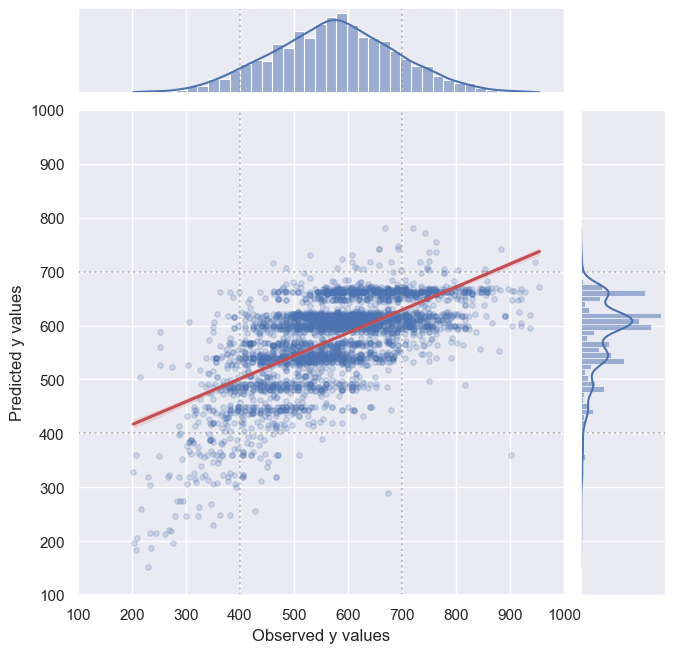

Model R squared: 0.4245
Prediction R squared: 0.4094 p-value: 0.0000
y = 0.4256x +331.0 


RESIDUALS PLOT


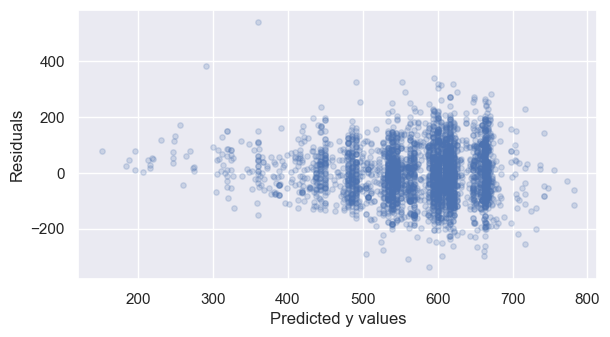

Breusch-Pegan Test for Heteroskedasticity:
If the test statistic has a p-value below 0.05, the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
Lagrange multiplier statistic: 193.6095, p-value: 0.0000

Homoskedasticity is rejected.



RESIDUALS NORMALITY
NormaltestResult(statistic=67.57233232658862, pvalue=2.1225330951546298e-15)
KstestResult(statistic=0.5073382407605299, pvalue=0.0, statistic_location=-3.3831512343256236, statistic_sign=1)
Residuals Histogram


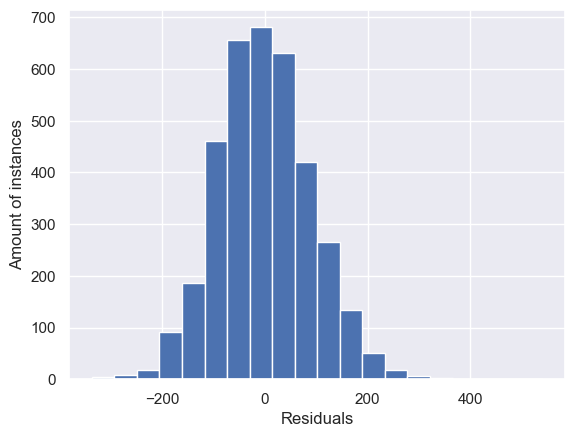

In [65]:
hc = 'HC0'
print(hc)
display(OLS_model_HC[hc].summary())
create_scatter(model_corr=OLS_model_HC[hc].rsquared, y_pred=y_pred_HC[hc], y_test=y_test_HC[hc], X_test=X_test_HC[hc])

### HC1

HC1


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 63, but rank is 56
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     1167.
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:08:15   Log-Likelihood:                -64664.
No. Observations:               10906   AIC:                         1.294e+05
Df Residuals:                   10849   BIC:                         1.299e+05
Df Model:                          56                                         
Covariance Type:                  HC1                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -9588.4957   2816.632     -3.404      0.001   -1.51e+04   -4067.998
work_year                 5.0063      1.392      3.596      0.000       2.278       7.735
job_name_AI              44.2020     10.865      4.068      0.000      22.908      65.496
job_name_Analytics       20.7852      5.145      4.040      0.000      10.702      30.868
job_name_Applied         55.0404      5.548      9.920      0.000      44.166      65.915
job_name_Architect       81.6433      6.060     13.474      0.000      69.767      93.520
job_name_Consultant     -76.3116      8.086     -9.438      0.000     -92.159     -60.464
job_name_Database      -134.7724     51.125     -2.636      0.008    -234.975     -34.570
job_name_Deep            83.1403     35.479      2.343      0.019      13.603     152.677
job_name_Director        75.9049     18.517      4.099      0.000      39.612     112.198
job_name_Head           115.6713     14.383      8.042      0.000      87.481     143.862
job_name_Lead            66.7610     14.117      4.729      0.000      39.092      94.430
job_name_Principal       73.0574     14.514      5.034      0.000      44.611     101.504
job_name_Product         65.7074     13.234      4.965      0.000      39.769      91.646
job_name_Prompt          78.4985     27.025      2.905      0.004      25.530     131.467
job_name_Quality        -43.8018     13.735     -3.189      0.001     -70.722     -16.882
job_name_Vision          66.3859     21.881      3.034      0.002      23.501     109.271
job_name_Machine         63.0041      2.986     21.101      0.000      57.152      68.856
job_name_Operations     -44.3495     11.962     -3.708      0.000     -67.794     -20.905
job_name_Cloud          141.8881     45.037      3.150      0.002      53.618     230.158
job_name_Engineer        60.5595      2.444     24.782      0.000      55.770      65.349
job_name_Research        47.6095      4.545     10.474      0.000      38.701      56.519
job_name_Scientist       77.6178      2.466     31.475      0.000      72.785      82.451
job_name_Manager         20.6664      5.512      3.749      0.000       9.863      31.469
experience_level_EN     -95.3703      3.565    -26.752      0.000    -102.358     -88.383
experience_level_EX      49.1448      6.362      7.724      0.000      36.675      61.615
experience_level_MI     -53.4945      2.179    -24.552      0.000     -57.765     -49.224
employment_type_FL     -122.8241     39.179     -3.135      0.002    -199.614     -46.034
employment_type_PT      -44.9524     21.145     -2.126      0.034     -86.397      -3.508
salary_currency_AUD    -145.2693     22.428     -6.477      0.000    -189.227    -101.311
salary_currency_CAD     -86.5248     12.879     -6.718      0.000    -111.767     -61.283
salary_currency_EUR    

,Observed,Predicted,Residual
count,3638.000000,3638.000000,3638.000000
mean,574.662719,575.599011,-0.936292
std,118.595406,78.883563,91.191079
min,202.834242,151.453313,-337.611664
25%,497.626500,539.249895,-63.887106
50%,574.230940,599.809397,-5.150926
75%,651.596109,620.594569,56.885400
max,954.368721,781.683754,541.373093


Scatter plot of Predicted vs Actual values


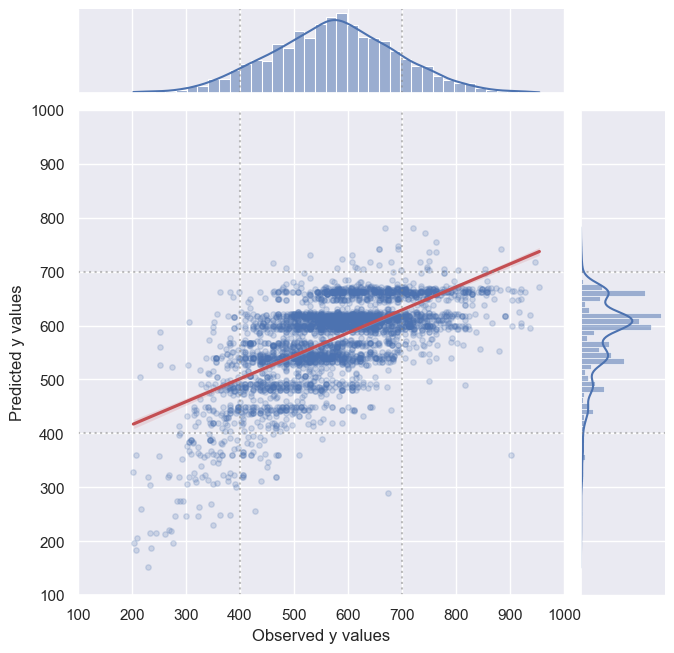

Model R squared: 0.4245
Prediction R squared: 0.4094 p-value: 0.0000
y = 0.4256x +331.0 


RESIDUALS PLOT


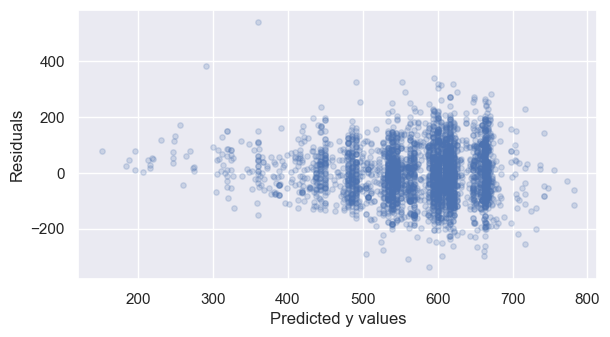

Breusch-Pegan Test for Heteroskedasticity:
If the test statistic has a p-value below 0.05, the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
Lagrange multiplier statistic: 193.6095, p-value: 0.0000

Homoskedasticity is rejected.



RESIDUALS NORMALITY
NormaltestResult(statistic=67.57233232658862, pvalue=2.1225330951546298e-15)
KstestResult(statistic=0.5073382407605299, pvalue=0.0, statistic_location=-3.3831512343256236, statistic_sign=1)
Residuals Histogram


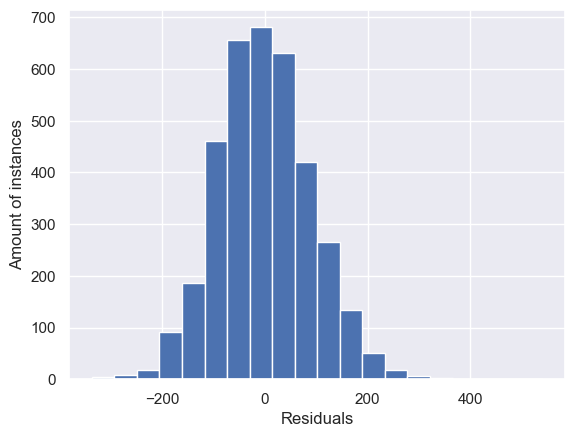

In [66]:
hc = 'HC1'
print(hc)
display(OLS_model_HC[hc].summary())
create_scatter(model_corr=OLS_model_HC[hc].rsquared, y_pred=y_pred_HC[hc], y_test=y_test_HC[hc], X_test=X_test_HC[hc])

### HC2

HC2


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 58, but rank is 52
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     1255.
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:08:17   Log-Likelihood:                -64681.
No. Observations:               10906   AIC:                         1.295e+05
Df Residuals:                   10853   BIC:                         1.299e+05
Df Model:                          52                                         
Covariance Type:                  HC2                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -9739.4861   2832.169     -3.439      0.001   -1.53e+04   -4188.536
work_year                 5.0810      1.400      3.630      0.000       2.337       7.825
job_name_AI              44.1522     10.954      4.031      0.000      22.682      65.623
job_name_Analytics       21.0677      5.152      4.089      0.000      10.970      31.165
job_name_Applied         54.8446      5.555      9.873      0.000      43.957      65.732
job_name_Architect       81.3157      6.068     13.400      0.000      69.422      93.209
job_name_Consultant     -75.9872      8.255     -9.205      0.000     -92.166     -59.808
job_name_Database      -134.4467     56.456     -2.381      0.017    -245.098     -23.796
job_name_Deep            85.3304     37.326      2.286      0.022      12.173     158.488
job_name_Director        77.6617     18.510      4.196      0.000      41.383     113.941
job_name_Head           113.7200     14.606      7.786      0.000      85.093     142.347
job_name_Lead            63.9144     14.651      4.362      0.000      35.198      92.630
job_name_Principal       78.0913     16.984      4.598      0.000      44.804     111.379
job_name_Product         65.6336     13.451      4.880      0.000      39.271      91.997
job_name_Prompt          78.6517     28.426      2.767      0.006      22.937     134.366
job_name_Quality        -43.7951     14.114     -3.103      0.002     -71.457     -16.133
job_name_Vision          67.2156     22.329      3.010      0.003      23.451     110.980
job_name_Machine         63.0114      2.991     21.069      0.000      57.150      68.873
job_name_Operations     -44.1318     12.038     -3.666      0.000     -67.726     -20.537
job_name_Cloud          141.7632     50.396      2.813      0.005      42.990     240.537
job_name_Engineer        60.3834      2.452     24.627      0.000      55.578      65.189
job_name_Research        47.3626      4.553     10.403      0.000      38.439      56.286
job_name_Scientist       77.6713      2.468     31.472      0.000      72.834      82.508
job_name_Manager         20.6425      5.516      3.742      0.000       9.830      31.455
experience_level_EN     -96.0450      3.566    -26.934      0.000    -103.034     -89.056
experience_level_EX      49.4495      6.366      7.767      0.000      36.972      61.927
experience_level_MI     -53.6134      2.183    -24.564      0.000     -57.891     -49.336
employment_type_FL     -126.0325     44.794     -2.814      0.005    -213.827     -38.238
salary_currency_AUD    -145.4205     23.125     -6.288      0.000    -190.745    -100.096
salary_currency_CAD     -86.7646     13.161     -6.593      0.000    -112.559     -60.970
salary_currency_EUR    -141.7778      7.747    -18.301      0.000    -156.961    -126.594
salary_currency_GBP    

,Observed,Predicted,Residual
count,3638.000000,3638.000000,3638.000000
mean,574.662719,575.565039,-0.902320
std,118.595406,78.695219,91.357879
min,202.834242,151.395808,-337.276028
25%,497.626500,539.284752,-63.384745
50%,574.230940,599.668114,-4.847368
75%,651.596109,620.600456,57.008950
max,954.368721,780.125610,541.237557


Scatter plot of Predicted vs Actual values


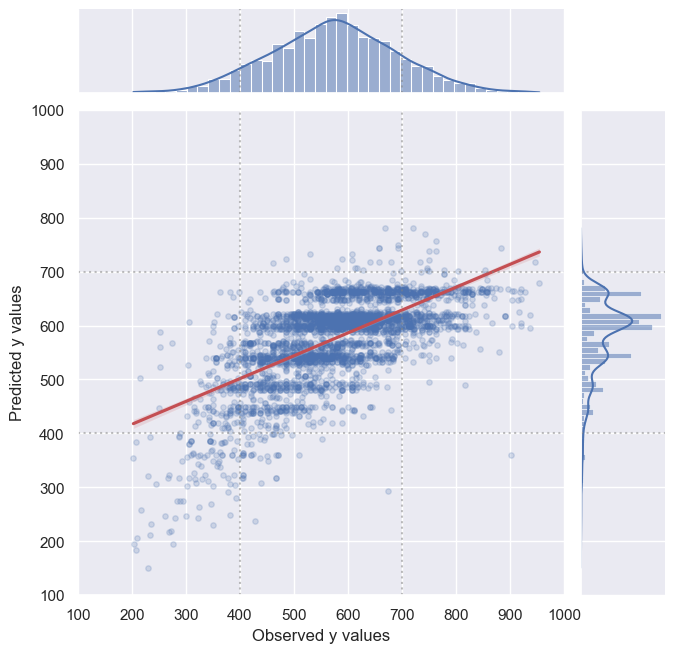

Model R squared: 0.4227
Prediction R squared: 0.4072 p-value: 0.0000
y = 0.4235x +332.2 


RESIDUALS PLOT


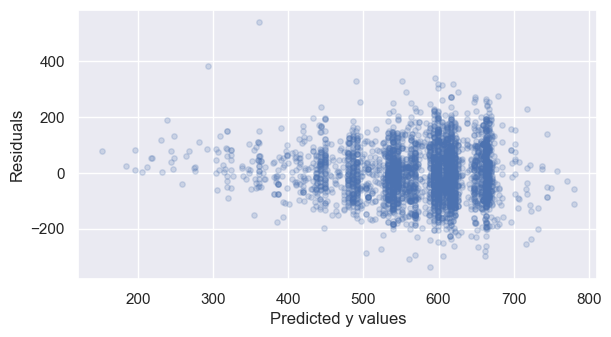

Breusch-Pegan Test for Heteroskedasticity:
If the test statistic has a p-value below 0.05, the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
Lagrange multiplier statistic: 191.1382, p-value: 0.0000

Homoskedasticity is rejected.



RESIDUALS NORMALITY
NormaltestResult(statistic=64.96741815128414, pvalue=7.807363440941935e-15)
KstestResult(statistic=0.5065656830843148, pvalue=0.0, statistic_location=-2.987634066343162, statistic_sign=1)
Residuals Histogram


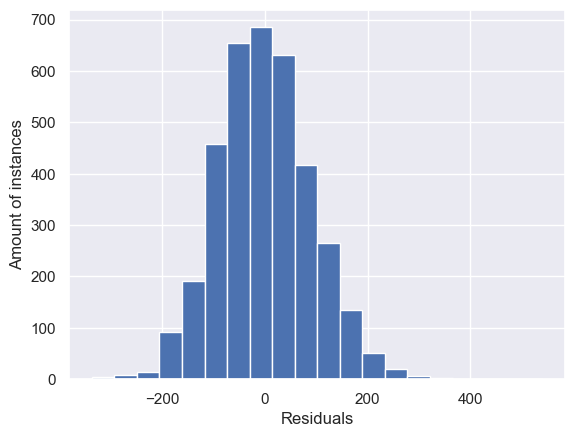

In [67]:
hc = 'HC2'
print(hc)
display(OLS_model_HC[hc].summary())
create_scatter(model_corr=OLS_model_HC[hc].rsquared, y_pred=y_pred_HC[hc], y_test=y_test_HC[hc], X_test=X_test_HC[hc])

### HC3

HC3


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 53, but rank is 47
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     230.5
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:08:20   Log-Likelihood:                -64687.
No. Observations:               10906   AIC:                         1.295e+05
Df Residuals:                   10858   BIC:                         1.298e+05
Df Model:                          47                                         
Covariance Type:                  HC3                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -9876.0164   2848.871     -3.467      0.001   -1.55e+04   -4292.332
work_year                 5.1485      1.408      3.656      0.000       2.389       7.908
job_name_AI              44.1174     11.023      4.002      0.000      22.513      65.721
job_name_Analytics       21.0770      5.162      4.083      0.000      10.959      31.195
job_name_Applied         54.5189      5.581      9.769      0.000      43.581      65.457
job_name_Architect       81.3457      6.083     13.373      0.000      69.423      93.268
job_name_Consultant     -76.0362      8.341     -9.116      0.000     -92.384     -59.688
job_name_Database      -134.1437     62.603     -2.143      0.032    -256.844     -11.444
job_name_Deep            85.4224     39.340      2.171      0.030       8.318     162.527
job_name_Director        78.3928     18.833      4.163      0.000      41.481     115.304
job_name_Head           114.0578     14.800      7.707      0.000      85.050     143.065
job_name_Lead            64.4808     14.752      4.371      0.000      35.567      93.395
job_name_Principal       78.4825     18.015      4.357      0.000      43.174     113.791
job_name_Product         65.4964     13.699      4.781      0.000      38.647      92.346
job_name_Prompt          81.8632     30.093      2.720      0.007      22.881     140.845
job_name_Quality        -43.9030     14.548     -3.018      0.003     -72.417     -15.389
job_name_Vision          62.3422     22.608      2.758      0.006      18.031     106.653
job_name_Machine         63.0353      3.000     21.012      0.000      57.155      68.915
job_name_Operations     -44.2543     12.146     -3.644      0.000     -68.059     -20.449
job_name_Cloud          141.3513     56.557      2.499      0.012      30.502     252.201
job_name_Engineer        60.3608      2.459     24.549      0.000      55.542      65.180
job_name_Research        47.2940      4.555     10.382      0.000      38.366      56.222
job_name_Scientist       77.5958      2.473     31.377      0.000      72.749      82.443
job_name_Manager         20.5763      5.534      3.718      0.000       9.730      31.422
experience_level_EN     -95.8872      3.580    -26.786      0.000    -102.903     -88.871
experience_level_EX      48.8806      6.403      7.634      0.000      36.331      61.430
experience_level_MI     -53.5979      2.191    -24.468      0.000     -57.891     -49.305
employment_type_FL     -112.9316     51.856     -2.178      0.029    -214.568     -11.295
salary_currency_AUD    -128.7314     12.676    -10.155      0.000    -153.577    -103.886
salary_currency_CAD     -86.8598     13.505     -6.432      0.000    -113.329     -60.390
salary_currency_EUR    -143.3626      7.155    -20.038      0.000    -157.385    -129.340
salary_currency_GBP    

,Observed,Predicted,Residual
count,3638.000000,3638.000000,3638.000000
mean,574.662719,575.519603,-0.856884
std,118.595406,78.816509,91.329003
min,202.834242,151.203269,-337.250373
25%,497.626500,539.390753,-63.298153
50%,574.230940,599.751529,-4.853301
75%,651.596109,620.736470,56.993076
max,954.368721,779.924977,541.136928


Scatter plot of Predicted vs Actual values


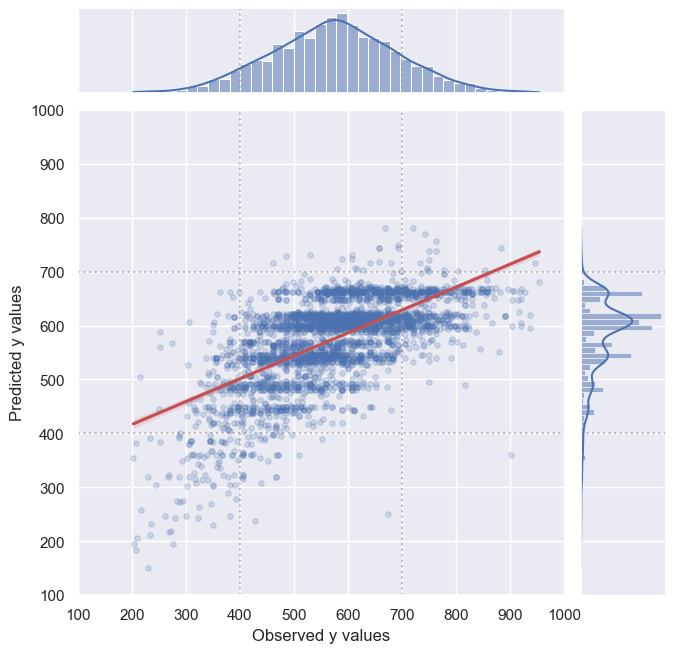

Model R squared: 0.4220
Prediction R squared: 0.4076 p-value: 0.0000
y = 0.4243x +331.7 


RESIDUALS PLOT


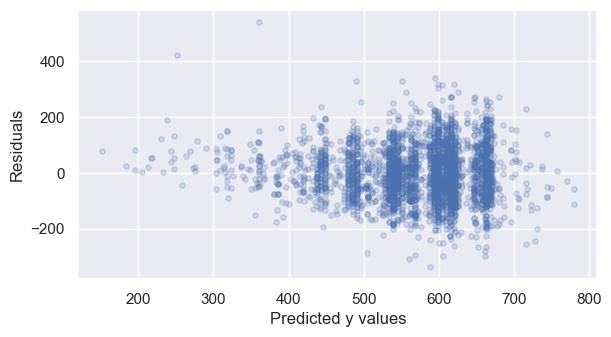

Breusch-Pegan Test for Heteroskedasticity:
If the test statistic has a p-value below 0.05, the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
Lagrange multiplier statistic: 195.9956, p-value: 0.0000

Homoskedasticity is rejected.



RESIDUALS NORMALITY
NormaltestResult(statistic=70.68256683451023, pvalue=4.482038972373539e-16)
KstestResult(statistic=0.5065603347347386, pvalue=0.0, statistic_location=-3.052107946259639, statistic_sign=1)
Residuals Histogram


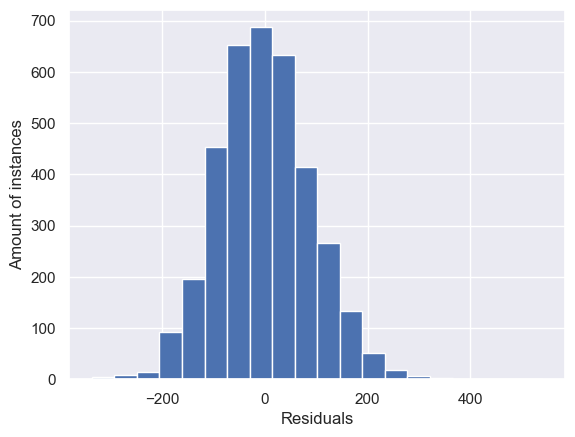

In [68]:
hc = 'HC3'
print(hc)
display(OLS_model_HC[hc].summary())
create_scatter(model_corr=OLS_model_HC[hc].rsquared, y_pred=y_pred_HC[hc], y_test=y_test_HC[hc], X_test=X_test_HC[hc])